In [2]:
# loading
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors  
from rdkit.Chem import Lipinski
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

#import pubchempy as pcp
#from IPython.display import Imag

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.ensemble import RandomForestRegressor

#import torch
from scipy import stats
import os

import joblib
import json

from openbabel import pybel

from itertools import chain


In [3]:
## Remove data column with std=0
def clean_std(df):
    print('Before clean', df.shape )
    #X_features.loc[ :, X_features.std() > X_features.mean() ]
    df_new = df.loc[ :, df.std()>0 ]
    print('After clean', df_new.shape )
    return df_new

# Remove high correlated data, step by step
def remove_high_corr_gradually(df, cutoff=0.9, highlight=None):
    corr_matx = df.corr()
    #sns.heatmap(corr_matx.abs())
    # The upper triangle of absolute values
    upper_tri = corr_matx.abs().where(np.triu(np.ones(corr_matx.shape),k=1).astype(bool))
    upper_tri = upper_tri>cutoff
    
    for n in range(len(upper_tri)):
        if upper_tri.sum().sum()>0:
            ## Find which one has the most overlap 
            occur = upper_tri.sum(axis=0).add( upper_tri.sum(axis=1) ).sort_values(ascending=False)
            bad_fp = list( occur.index )[0]
            #print( bad_fp, occur[bad_fp])
            upper_tri.drop( bad_fp, axis=1, inplace=True)
            upper_tri.drop( bad_fp, axis=0, inplace=True)
        else:
            break
    
    print("Num of keep: ",len(upper_tri.columns))
    print("Num of drop: ",len(df.columns)-len(upper_tri.columns))
    print("---------")
    
    if highlight is not None:
        highlight = corr_matx[ highlight ]
        
    return  df[ upper_tri.columns ], highlight

## Standardization of a pd dataframe
def get_std(data_x):   
    scaler = StandardScaler()
    scaler.fit(data_x)
    X_scale = scaler.transform(data_x)
    data_new = pd.DataFrame(X_scale, columns=data_x.columns, index=data_x.index)
    return data_new, scaler  ## Save the new data, and its scaler

# Standardization of a dict of pd dataframe
def standard_dataset(dataset_dict):
    dataset_new = dataset_dict.copy()
    x_train, scaler = get_std(dataset_dict['x_train'])
    x_test = scaler.transform(dataset_dict['x_test'])
    x_test = pd.DataFrame(x_test, columns=dataset_dict['x_test'].columns, index=dataset_dict['x_test'].index)
    x_val = scaler.transform(dataset_dict['x_val'])
    x_val = pd.DataFrame(x_val, columns=dataset_dict['x_val'].columns, index=dataset_dict['x_val'].index)
    dataset_new['x_train'] = x_train
    dataset_new['x_test'] = x_test
    dataset_new['x_val'] = x_val
    dataset_new['scaler'] = scaler
    return dataset_new

## split train, text, valid
def split_data(x,y, rand_state=0):
    # Assign 20% data as testing data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state =rand_state, shuffle = True)
    # Assign 20% data as val data, so train data is 60%.  val size = 0.8*0.125 = 0.1
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=rand_state)    
    print("Train, Test, Val sizes are: ", x_train.shape, x_test.shape, x_val.shape)

    return  x_train, x_test, x_val, y_train, y_test, y_val

## Call lazypredictor
from lazypredict.Supervised import LazyRegressor

def do_lazy_regression(data_dict, ylabel=None, rg="all"):
    reg = LazyRegressor(verbose=2,ignore_warnings=False, custom_metric=None, regressors=rg)
    if ylabel is not None:
        models,predictions = reg.fit(data_dict['x_train'], data_dict['x_test'], data_dict['y_train'][ylabel], data_dict['y_test'][ylabel])
    else:
        models,predictions = reg.fit(data_dict['x_train'], data_dict['x_test'], data_dict['y_train'], data_dict['y_test'])
    return models, predictions

def know_any_depth(x_train, y_train, x_test, y_test, model_algorithm, name='None', max_layer=20, vb=0):
    values = [i for i in range(1, max_layer)]  ## depth of tree
    train_scores, test_scores =[], []
    r2_train,rmse_train,r2_test,rmse_test = [],[],[],[]
    # evaluate a decision tree for each depth
    for i in values:
        model = model_algorithm(max_depth=i, verbose=vb)
        model.fit(x_train, y_train)
        y_pred_train=model.predict(x_train)
        y_pred_test=model.predict(x_test)
        r2_train.append( metrics.r2_score(y_train, y_pred_train) )
        rmse_train.append( metrics.mean_squared_error(y_train, y_pred_train, squared=False) )
        r2_test.append( metrics.r2_score(y_test, y_pred_test) )
        rmse_test.append( metrics.mean_squared_error(y_test, y_pred_test, squared=False) )
        # summarize progress
        print('>%d, train: %.3f, test: %.3f' % (i, r2_train[-1], r2_test[-1]))
    # plot of train and test scores vs tree depth
    fig, axs = plt.subplots(1,2,figsize=(12,6),tight_layout=True)
    axs[0].plot(values, r2_train, '-o', label='Train')
    axs[0].plot(values, r2_test, '-o', label='Test')
    axs[0].set_xticks( np.arange(1,max_layer+1,1) )
    axs[0].grid(axis='both',color='g')
    axs[0].legend()
    axs[0].set_title('R2')
    axs[1].plot(values, rmse_train, '-o', label='Train')
    axs[1].plot(values, rmse_test, '-o', label='Test')
    axs[1].set_xticks( np.arange(1,max_layer+1,1) )
    axs[1].grid(axis='both',color='g')
    axs[1].legend()
    axs[1].set_title('RMSE')
    #pyplot.savefig("testtrain90-10.png", dpi=300)
    plt.show()
    print("=============Done==============")
    
def model_any_fit(x_train,y_train, x_test,y_test, model_algorithm, name='None',vb=0, axs_lim=None,savefig=None, depth=20, ml_parameter=None):
    if ml_parameter is None:
        model = model_algorithm( max_depth=depth, verbose=vb )
    else:
        model = model_algorithm(verbose=vb, **ml_parameter)
    model = model.fit(x_train, y_train)
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))    
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

    print("================ Info =================")
    print(">>>>>> Train set", x_train.shape)
    print("R square score: " , r2_train)
    print("RMSE, MAE: ", rmse_train, mae_train)
    print(">>>>>> Test set", x_test.shape)
    print("R square score: " , r2_test)
    print("RMSE, MAE: ", rmse_test, mae_test)
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True)
    axs.plot(y_train, y_pred_train, 'o', color='orange', label='Training',alpha=0.8, markersize=5)           # scatter plot showing actual data
    axs.plot(y_test, y_pred_test, 'v', color='g', label='Testing',alpha=0.2, markersize=3)           # scatter plot showing actual data
    axs.plot([-100,100], [-100,100], '--', color='k') 

    a_train, b_train = np.polyfit(y_train, y_pred_train, 1)
    a_test, b_test = np.polyfit(y_test, y_pred_test, 1)
    if axs_lim is None:
        ax_min = np.amin([np.amin(y_train), np.amin(y_test)])-0.3
        ax_max = np.amax([np.amax(y_train), np.amax(y_test)])+0.3
        axs.set_xlim((ax_min,ax_max))
        axs.set_ylim((ax_min,ax_max))
    else:
        axs.set_xlim(axs_lim)
        axs.set_ylim(axs_lim)

    axs.set_xlabel('Reference ',fontsize=10) ## input X name
    axs.set_ylabel('ML prediction',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    
    axs.legend(fontsize=8, frameon=False,)
    plt.title(name)
        
    r2_train, rmse_train, mae_train, r2_test, rmse_test, mae_test = np.round([r2_train,rmse_train,mae_train,r2_test,rmse_test,mae_test], 2)
    performance_train = f'R$^2$: {r2_train}\nRMSE: {rmse_train}\nMAE: {mae_train}'
    performance_test = f'R$^2$: {r2_test}\nRMSE: {rmse_test}\nMAE: {mae_test}'
    axs.text(0.65,0.25, performance_train, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white',color='orange')
    axs.text(0.65,0.05, performance_test,  style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white',color='g')

    if savefig is not None:
        plt.savefig(savefig, dpi=800)
    plt.show()
    return model

## Evaluate validation data
def score_val(x_val, y_val, model, name='',axs_lim=None, savefig=None, alpha=0.5):
    y_predict_val = model.predict(x_val)
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True )#,dpi=100)
    #axs.plot(y_val, y_predict_val, 'o', color='r',label='Validating')  
    
    x,y,z = color_density(y_val, y_predict_val)
    #z = plt.cm.jet(z)            
    im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=alpha, s=10) 
    
    axs.plot([-100,100], [-100,100], '--', color='k', lw=1)
    
    a, b = np.polyfit(y_val, y_predict_val, 1)
    #axs.plot(y_val, a*y_val+b, color='r') 
    
    r2_val = metrics.r2_score(y_val, y_predict_val)
    rmse_val = np.sqrt(metrics.mean_squared_error(y_val, y_predict_val))    
    mae_val = metrics.mean_absolute_error(y_val, y_predict_val)
    print(">>>>>> Val set", y_val.shape)
    print("R square score: " , r2_val)
    print("RMSE, MAE:", rmse_val, mae_val)
    
    #plt.text(-11,-6.5, 'R^2 = 0.811')
    if axs_lim is None:
        ax_min = np.amin([np.amin(y_train), np.amin(y_test)])-0.1
        ax_max = np.amax([np.amax(y_train), np.amax(y_test)])+0.1
        axs.set_xlim((ax_min,ax_max))
        axs.set_ylim((ax_min,ax_max))
    else:
        axs.set_xlim(axs_lim)
        axs.set_ylim(axs_lim)
    
    axs.set_xlabel('Reference ',fontsize=10) ## input X name
    axs.set_ylabel('ML prediction',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    
    plt.title(name)
    #fig.colorbar(im, shrink=0.5, label='Density')

    r2_val, rmse_val, mae_val = np.round([r2_val, rmse_val, mae_val], 2)
    performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}\nMAE: {mae_val}'
    axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
    #axs.legend(fontsize=8, frameon=False,)
    if savefig is not None:
        plt.savefig(savefig, dpi=800)      
    plt.show()
    
    return r2_val, rmse_val, mae_val
    
def color_density(x,y):
    x= np.array(x)
    y= np.array(y)
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    return x,y,z

def xyz_to_smiles(fname: str) -> str:
    mol = next(pybel.readfile("xyz", fname))
    smi = mol.write(format="smi")
    return smi.split()[0].strip()

def smiles_to_xyz_pybel(smi, if_write_xyz='molecule.xyz', if_overwrite=False):
    mol = pybel.readstring("smi", smi)
    mol.addh() # add Hs for 3D
    mol.make3D() # generate 3D coordinates
    if if_write_xyz is not None:
        xyz = mol.write(format='xyz',filename=if_write_xyz, overwrite=if_overwrite)
    else:
        xyz = mol.write(format='xyz')
    return xyz

In [4]:
import scipy.stats as stats

def see_correlation(df, xlabel, ylabel='LUMO', color=None):
    fig, axs = plt.subplots(1,1, figsize=(5,4),tight_layout=True)
    y= np.array(df[ylabel])
    x= np.array(df[xlabel])
    if color is None:
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    else:
        z = color
    #z = plt.cm.jet(z) 
    
    correlation_coefficient = stats.pearsonr(x, y)[0]
    print(correlation_coefficient)

    im = axs.scatter( x,y, c=z, marker='o', cmap='jet',alpha=0.5, edgecolors='none', s=20)
    axs.set_ylabel(ylabel,fontsize=14) ## input X name
    axs.set_xlabel(xlabel,fontsize=14) ## input Y name
    axs.tick_params(direction='in',labelsize='10')
    plt.show()

# Read dataset 

In [5]:
df_pnl = pd.read_csv('df_final_pnl_cccc.csv', index_col=0)
df_qm9 = pd.read_csv('df_final_qm9_cccc.csv', index_col=0)
df_qm9_N = pd.read_csv('df_final_qm9_n_diene.csv', index_col=0)

df_qm9_N_1 = df_qm9_N[df_qm9_N['diene_types']==1]
df_qm9_N_2 = df_qm9_N[df_qm9_N['diene_types']==2]
df_qm9_N_3 = df_qm9_N[df_qm9_N['diene_types']==3]
df_qm9_N_4 = df_qm9_N[df_qm9_N['diene_types']==4]

display('Read: ', df_pnl.shape, df_qm9.shape, df_qm9_N_1.shape, df_qm9_N_2.shape, df_qm9_N_3.shape, df_qm9_N_4.shape)

feature_col = ['LUMO'] + [c for c in df_qm9_N.columns if 'rdk_' in c ] #or 'RingCount_' in c ]   
df_pnl =df_pnl[feature_col]
df_qm9 =df_qm9[feature_col]
df_qm9_N_1 =df_qm9_N_1[feature_col]
df_qm9_N_2 =df_qm9_N_2[feature_col]
df_qm9_N_3 =df_qm9_N_3[feature_col]
df_qm9_N_4 =df_qm9_N_4[feature_col]

df_final = pd.concat( [df_pnl, df_qm9, df_qm9_N_1, df_qm9_N_2, df_qm9_N_3, df_qm9_N_4],axis=0 )
df_final.drop_duplicates()

'Read: '

(2583, 2408)

(3382, 2409)

(6120, 2386)

(3080, 2386)

(357, 2386)

(67, 2386)

,LUMO,rdk_MaxEStateIndex,rdk_MinEStateIndex,rdk_MaxAbsEStateIndex,rdk_MinAbsEStateIndex,rdk_qed,rdk_MolWt,rdk_HeavyAtomMolWt,rdk_ExactMolWt,rdk_NumValenceElectrons,...,rdk_NumHAcceptors,rdk_NumHDonors,rdk_NumHeteroatoms,rdk_NumRotatableBonds,rdk_NumSaturatedCarbocycles,rdk_NumSaturatedHeterocycles,rdk_NumSaturatedRings,rdk_RingCount,rdk_MolLogP,rdk_MolMR
257,-3.29,9.66,0.29,9.66,0.29,0.23,107.11,102.07,107.04,40,...,2,0,2,2,0,0,0,0,0.82,29.96
1375,-3.25,9.56,0.65,9.56,0.65,0.23,107.11,102.07,107.04,40,...,2,0,2,2,0,0,0,0,0.82,29.96
4352,-3.16,9.56,0.65,9.56,0.65,0.23,107.11,102.07,107.04,40,...,2,0,2,2,0,0,0,0,0.82,29.96
2759,-3.14,9.84,0.31,9.84,0.31,0.23,107.11,102.07,107.04,40,...,2,0,2,2,0,0,0,0,0.82,29.96
1759,-3.13,9.66,0.29,9.66,0.29,0.23,107.11,102.07,107.04,40,...,2,0,2,2,0,0,0,0,0.82,29.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18553,-1.14,3.60,0.82,3.60,0.82,0.57,127.15,118.08,127.09,50,...,5,0,5,3,0,0,0,1,-0.13,30.52
17096,-1.14,8.77,-0.46,8.77,0.34,0.52,129.12,122.07,129.07,50,...,6,1,6,2,0,0,0,1,-1.55,27.29
6645,-1.09,3.56,0.25,3.56,0.25,0.50,113.12,106.07,113.07,44,...,5,0,5,1,0,0,0,1,-0.35,26.00
18195,-1.05,3.63,0.31,3.63,0.31,0.56,127.15,118.08,127.09,50,...,5,0,5,2,0,0,0,1,0.04,30.61


In [6]:
feature_col = [c for c in df_final.columns if 'rdk_' in c ]
X_features = df_final[feature_col]

X_features = clean_std(X_features)
X_features_prop_clean, _= remove_high_corr_gradually(X_features, cutoff=0.8 )
feature_col = list( X_features_prop_clean.columns )

feature_col = ['LUMO'] + feature_col
df_pnl =df_pnl[feature_col]
df_qm9 =df_qm9[feature_col]
df_qm9_N_1 =df_qm9_N_1[feature_col]
df_qm9_N_2 =df_qm9_N_2[feature_col]
df_qm9_N_3 =df_qm9_N_3[feature_col]
df_qm9_N_4 =df_qm9_N_4[feature_col]

df_pnl['type']= -1
df_qm9['type']=0
df_qm9_N_1['type']=1
df_qm9_N_2['type']=2
df_qm9_N_3['type']=3
df_qm9_N_4['type']=4

display('Final: ', df_pnl.shape, df_qm9.shape, df_qm9_N_1.shape, df_qm9_N_2.shape, df_qm9_N_3.shape, df_qm9_N_4.shape)

data_prop = []
for df in [df_pnl, df_qm9, df_qm9_N_1, df_qm9_N_2, df_qm9_N_3, df_qm9_N_4]:
    Y_prop = df[['LUMO','type']]
    X_prop = df.drop(['LUMO','type'],axis=1)
    data_prop.append( [X_prop,Y_prop] )

Before clean (15589, 122)
After clean (15589, 117)
Num of keep:  84
Num of drop:  33
---------


'Final: '

(2583, 86)

(3382, 86)

(6120, 86)

(3080, 86)

(357, 86)

(67, 86)

In [ ]:
corr_matx = df_final.corr()
corr_matx['type'][ corr_matx['type'].abs()>0.8 ]
see_correlation( df_final, xlabel='rdk_SMR_VSA3', ylabel='type', color='r')

### See ML performance

Train, Test, Val sizes are:  (1549, 84) (517, 84) (517, 84)
Train, Test, Val sizes are:  (2028, 84) (677, 84) (677, 84)
Train, Test, Val sizes are:  (3672, 84) (1224, 84) (1224, 84)
Train, Test, Val sizes are:  (1848, 84) (616, 84) (616, 84)
Train, Test, Val sizes are:  (213, 84) (72, 84) (72, 84)
Train, Test, Val sizes are:  (39, 84) (14, 84) (14, 84)


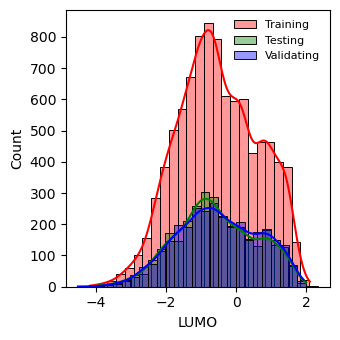

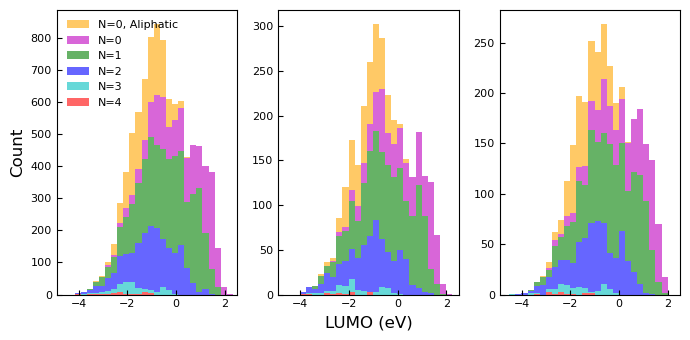

In [8]:
# The order is: df_pnl, df_qm9, df_qm9_N_1, df_qm9_N_2, df_qm9_N_3, df_qm9_N_4
use_index = [0,1,2,3,4,5] # loop which subsets
all_prop = []  
for i in use_index:
    X_prop = data_prop[i][0]
    Y_prop = data_prop[i][1]
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=123456)
    data = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    all_prop.append( data )
    
df_prop = {}  ## All together 
for k in all_prop[0].keys():  ## loop x_train,xtest,...
    df = pd.concat( [ data[k] for data in all_prop ] ,axis=0 )
    df_prop[k] = df

fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)
#df_prop['y_val'].plot(kind='bar', stacked=False, x='type', y='LUMO', ax=axs)
sns.histplot(df_prop['y_train']['LUMO'],  kde=True, color='r', alpha=0.4, label='Training', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='g', alpha=0.4, label='Testing', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='b', alpha=0.4, label='Validating', binwidth=0.25, ax=axs)
axs.legend(fontsize=8, frameon=False)
plt.show()

colors = ['orange','m','g','b','c','r']
fig, axs = plt.subplots(1,3,figsize=(7,3.5),tight_layout=True,dpi=100)
sns.histplot(df_prop['y_train'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[0], x="LUMO", hue="type", element="step", legend=True, multiple="stack")
sns.histplot(df_prop['y_test'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[1], x="LUMO", hue="type", element="step", legend=False, multiple="stack")
sns.histplot(df_prop['y_val'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[2], x="LUMO", hue="type", element="step", legend=False, multiple="stack")
legend = axs[0].get_legend()
handles = legend.legendHandles
#legend.remove()
axs[0].legend(handles, ['N=0, Aliphatic','N=0','N=1','N=2','N=3','N=4'], fontsize=8, frameon=False, loc=2)
for n in range(3):
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_xticks( [] )
    axs[n].set_xlim((-4.9,2.5))
    axs[n].set_ylim(bottom=0)
    axs[n].tick_params(direction='in',labelsize=8)
    #axs[n].legend_.remove()
axs[1].set_xlabel('LUMO (eV)', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)
plt.show()

In [ ]:
df_prop_std = standard_dataset(df_prop)
df_prop = df_prop_std
df_prop.keys()

In [9]:
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin

import xgboost
import lightgbm

removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression", 
    "CCA", 
    "IsotonicRegression", 
    "StackingRegressor",
    "MultiOutputRegressor", 
    "MultiTaskElasticNet", 
    "MultiTaskElasticNetCV", 
    "MultiTaskLasso", 
    "MultiTaskLassoCV", 
    "PLSCanonical", 
    "PLSRegression", 
    "RadiusNeighborsRegressor", 
    "RegressorChain", 
    "VotingRegressor",
    
    "PoissonRegressor",
    "QuantileRegressor",
]

chosen_regressors = [
    'SVR',
    'BaggingRegressor'
]

my_REGRESSORS = [
    est
    for est in all_estimators()
    #if (issubclass(est[1], RegressorMixin) and (est[0] in chosen_regressors))
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))  
]

my_REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
my_REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))

for i,r in enumerate(my_REGRESSORS):
    print(i, r[0])

0 AdaBoostRegressor
1 BaggingRegressor
2 BayesianRidge
3 DecisionTreeRegressor
4 DummyRegressor
5 ElasticNet
6 ElasticNetCV
7 ExtraTreeRegressor
8 ExtraTreesRegressor
9 GammaRegressor
10 GaussianProcessRegressor
11 GradientBoostingRegressor
12 HistGradientBoostingRegressor
13 HuberRegressor
14 KNeighborsRegressor
15 KernelRidge
16 Lars
17 LarsCV
18 Lasso
19 LassoCV
20 LassoLars
21 LassoLarsCV
22 LassoLarsIC
23 LinearRegression
24 LinearSVR
25 MLPRegressor
26 NuSVR
27 OrthogonalMatchingPursuit
28 OrthogonalMatchingPursuitCV
29 PassiveAggressiveRegressor
30 RANSACRegressor
31 RandomForestRegressor
32 Ridge
33 RidgeCV
34 SGDRegressor
35 SVR
36 TransformedTargetRegressor
37 TweedieRegressor
38 XGBRegressor
39 LGBMRegressor


In [9]:
model_da, lazy_da = do_lazy_regression(df_prop, ylabel='LUMO', rg=my_REGRESSORS)
model_da

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  2%|▎         | 1/40 [00:03<02:28,  3.80s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7636510047271972, 'Adjusted R-Squared': 0.7571095498333206, 'RMSE': 0.5559093192145661, 'Time taken': 3.801145315170288}


  5%|▌         | 2/40 [00:09<03:12,  5.08s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9423137894603366, 'Adjusted R-Squared': 0.9407172024140988, 'RMSE': 0.27463955055371553, 'Time taken': 5.965728521347046}
{'Model': 'BayesianRidge', 'R-Squared': 0.9075111739581365, 'Adjusted R-Squared': 0.9049513514251821, 'RMSE': 0.3477536586750192, 'Time taken': 0.08242487907409668}


 10%|█         | 4/40 [00:10<01:17,  2.17s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.8875807222995991, 'Adjusted R-Squared': 0.8844692826531959, 'RMSE': 0.38339590475912283, 'Time taken': 0.7872738838195801}
{'Model': 'DummyRegressor', 'R-Squared': -0.0015263093244672898, 'Adjusted R-Squared': -0.029245653635259883, 'RMSE': 1.1443483704915731, 'Time taken': 0.04520869255065918}
{'Model': 'ElasticNet', 'R-Squared': 0.12360706111536501, 'Adjusted R-Squared': 0.0993510456734179, 'RMSE': 1.0704749508505174, 'Time taken': 0.044220924377441406}


 18%|█▊        | 7/40 [00:11<00:33,  1.01s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.887253865831321, 'Adjusted R-Squared': 0.8841333797455981, 'RMSE': 0.38395285761537, 'Time taken': 0.37760448455810547}


 20%|██        | 8/40 [00:11<00:27,  1.17it/s]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8628657009941945, 'Adjusted R-Squared': 0.8590702212194045, 'RMSE': 0.4234480329624752, 'Time taken': 0.2888367176055908}


 22%|██▎       | 9/40 [00:34<03:07,  6.06s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9593487443884854, 'Adjusted R-Squared': 0.9582236355017087, 'RMSE': 0.23054943196816333, 'Time taken': 23.04111123085022}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 28%|██▊       | 11/40 [00:48<03:07,  6.47s/it]

{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.007492599295565894, 'Adjusted R-Squared': -0.019977127775001602, 'RMSE': 1.1391841957908768, 'Time taken': 14.120093584060669}


 30%|███       | 12/40 [01:03<03:56,  8.44s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9100939855108927, 'Adjusted R-Squared': 0.9076056477128416, 'RMSE': 0.3428636524864571, 'Time taken': 15.337260484695435}


 32%|███▎      | 13/40 [01:05<03:02,  6.76s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9603431238424158, 'Adjusted R-Squared': 0.959245536495715, 'RMSE': 0.22771221348257428, 'Time taken': 1.4855692386627197}


 38%|███▊      | 15/40 [01:06<01:35,  3.83s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.9042856662895911, 'Adjusted R-Squared': 0.9016365710567494, 'RMSE': 0.353765571121782, 'Time taken': 0.5325987339019775}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.8930502679676835, 'Adjusted R-Squared': 0.8900902094863937, 'RMSE': 0.37395291654368534, 'Time taken': 0.18111848831176758}


 40%|████      | 16/40 [01:09<01:28,  3.69s/it]

{'Model': 'KernelRidge', 'R-Squared': 0.6874890111824239, 'Adjusted R-Squared': 0.6788396131393675, 'RMSE': 0.639233785705607, 'Time taken': 3.333707332611084}
{'Model': 'Lars', 'R-Squared': -123663409742525.5, 'Adjusted R-Squared': -127086054361429.05, 'RMSE': 12715916.952113792, 'Time taken': 0.07660770416259766}


 45%|████▌     | 18/40 [01:09<00:46,  2.13s/it]

{'Model': 'LarsCV', 'R-Squared': 0.63138558742787, 'Adjusted R-Squared': 0.6211834092874882, 'RMSE': 0.6942457507694064, 'Time taken': 0.2543201446533203}
{'Model': 'Lasso', 'R-Squared': -0.0015263093244672898, 'Adjusted R-Squared': -0.029245653635259883, 'RMSE': 1.1443483704915731, 'Time taken': 0.06233072280883789}


 50%|█████     | 20/40 [01:10<00:27,  1.39s/it]

{'Model': 'LassoCV', 'R-Squared': 0.887050347669851, 'Adjusted R-Squared': 0.8839242287915207, 'RMSE': 0.38429923821976497, 'Time taken': 0.3800771236419678}
{'Model': 'LassoLars', 'R-Squared': -0.0015263093244672898, 'Adjusted R-Squared': -0.029245653635259883, 'RMSE': 1.1443483704915731, 'Time taken': 0.05531144142150879}


 57%|█████▊    | 23/40 [01:10<00:13,  1.26it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.8862775065006343, 'Adjusted R-Squared': 0.8831299976195974, 'RMSE': 0.385611752020173, 'Time taken': 0.3381171226501465}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9078824571287414, 'Adjusted R-Squared': 0.9053329106374116, 'RMSE': 0.34705495308125256, 'Time taken': 0.10898613929748535}
{'Model': 'LinearRegression', 'R-Squared': 0.9078679142966293, 'Adjusted R-Squared': 0.9053179653018737, 'RMSE': 0.34708234722667086, 'Time taken': 0.07841157913208008}


 62%|██████▎   | 25/40 [01:12<00:12,  1.16it/s]

{'Model': 'LinearSVR', 'R-Squared': 0.9031865865922448, 'Adjusted R-Squared': 0.9005070720201686, 'RMSE': 0.35579090378469486, 'Time taken': 1.869128704071045}


 65%|██████▌   | 26/40 [01:16<00:19,  1.41s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.9456144843772537, 'Adjusted R-Squared': 0.9441092509959322, 'RMSE': 0.2666666465708519, 'Time taken': 3.4997687339782715}


 72%|███████▎  | 29/40 [01:24<00:19,  1.79s/it]

{'Model': 'NuSVR', 'R-Squared': 0.9660909357939983, 'Adjusted R-Squared': 0.9651524312163033, 'RMSE': 0.2105644143195232, 'Time taken': 8.023500680923462}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.7711685237424689, 'Adjusted R-Squared': 0.7648351319778453, 'RMSE': 0.5469970139520792, 'Time taken': 0.04937863349914551}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.7711685237424689, 'Adjusted R-Squared': 0.7648351319778453, 'RMSE': 0.5469970139520792, 'Time taken': 0.08152294158935547}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.7833918484827936, 'Adjusted R-Squared': 0.7773967629053816, 'RMSE': 0.532187258365144, 'Time taken': 0.05175495147705078}


 78%|███████▊  | 31/40 [01:24<00:10,  1.21s/it]

{'Model': 'RANSACRegressor', 'R-Squared': -1.9125665531279314e+18, 'Adjusted R-Squared': -1.965500849820764e+18, 'RMSE': 1581376762.0111473, 'Time taken': 0.2913689613342285}


 85%|████████▌ | 34/40 [02:25<00:50,  8.46s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9515777313761408, 'Adjusted R-Squared': 0.9502375433812794, 'RMSE': 0.25162259716031316, 'Time taken': 60.54433846473694}
{'Model': 'Ridge', 'R-Squared': 0.9073442168877696, 'Adjusted R-Squared': 0.9047797734672004, 'RMSE': 0.34806739254055996, 'Time taken': 0.04735755920410156}
{'Model': 'RidgeCV', 'R-Squared': 0.9078798031190711, 'Adjusted R-Squared': 0.9053301831724491, 'RMSE': 0.34705995256635924, 'Time taken': 0.0924835205078125}
{'Model': 'SGDRegressor', 'R-Squared': -332628.5792451174, 'Adjusted R-Squared': -341834.8015372393, 'RMSE': 659.4889263246519, 'Time taken': 0.06761670112609863}


 95%|█████████▌| 38/40 [02:30<00:08,  4.32s/it]

{'Model': 'SVR', 'R-Squared': 0.9656571932218222, 'Adjusted R-Squared': 0.9647066839073685, 'RMSE': 0.2119068362518937, 'Time taken': 5.084304332733154}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9078679142966293, 'Adjusted R-Squared': 0.9053179653018737, 'RMSE': 0.34708234722667086, 'Time taken': 0.07038044929504395}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7834841621109565, 'Adjusted R-Squared': 0.7774916315071082, 'RMSE': 0.5320738430301578, 'Time taken': 0.031247377395629883}
{'Model': 'XGBRegressor', 'R-Squared': 0.9582836399682017, 'Adjusted R-Squared': 0.957129052079348, 'RMSE': 0.23355021844837243, 'Time taken': 1.7258760929107666}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12470
[LightGBM] [Info] Number of data points in the train set: 9349, number of used features: 82
[LightGBM] [Info] Start training from score 

100%|██████████| 40/40 [02:32<00:00,  3.82s/it]

{'Model': 'LGBMRegressor', 'R-Squared': 0.9600736293581957, 'Adjusted R-Squared': 0.9589685831855725, 'RMSE': 0.2284846303575502, 'Time taken': 0.27952075004577637}


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
NuSVR,0.97,0.97,0.21,8.02
SVR,0.96,0.97,0.21,5.08
HistGradientBoostingRegressor,0.96,0.96,0.23,1.49
LGBMRegressor,0.96,0.96,0.23,0.28
ExtraTreesRegressor,0.96,0.96,0.23,23.04
XGBRegressor,0.96,0.96,0.23,1.73
RandomForestRegressor,0.95,0.95,0.25,60.54
MLPRegressor,0.94,0.95,0.27,3.50
BaggingRegressor,0.94,0.94,0.27,5.97


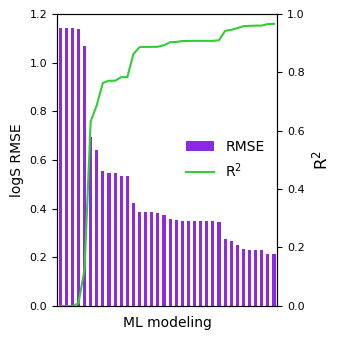

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LassoLars,-0.03,-0.00,1.14,0.06
DummyRegressor,-0.03,-0.00,1.14,0.05
Lasso,-0.03,-0.00,1.14,0.06
GaussianProcessRegressor,-0.02,0.01,1.14,14.12
ElasticNet,0.10,0.12,1.07,0.04
LarsCV,0.62,0.63,0.69,0.25
KernelRidge,0.68,0.69,0.64,3.33
AdaBoostRegressor,0.76,0.76,0.56,3.80
OrthogonalMatchingPursuitCV,0.76,0.77,0.55,0.08


In [10]:
rmse = model_da[ model_da['RMSE']<5 ].sort_values(by='RMSE',ascending=False)

fig, axs = plt.subplots(1,1,  figsize=(3.5,3.5),tight_layout=True)
rmse.plot(kind='bar', y=['RMSE'], color=['blueviolet'], ax=axs, legend=False, fontsize=8)  ##figsize=(12,3)

axs.set_ylabel('logS RMSE', fontsize=10)
axs.set_xlabel('ML modeling', fontsize=10)
axs.set_xticklabels( [n for n in range(len(rmse))], rotation=0, ha='center')

axt = axs.twinx()
axt.set_xticks( [] )
axt.set_ylabel('R$^2$', fontsize=12)
rmse.plot(kind='line', y=['R-Squared'], color=['limegreen'], ax=axt, legend=False, fontsize=8, xlabel=None)
axt.set_ylim((0,1))

rr = np.round( [rmse['R-Squared'].tail(1), rmse['RMSE'].tail(1)], 2)
rr = f'Best performance:\nRMSE={rr[1][0]}\nR2 score={rr[0][0]}'
#axs.text(0.4,0.6, rr, style='italic', fontsize=12, transform = axs.transAxes, color='k')

#axs.legend(fontsize=8, frameon=False)
#axt.legend(fontsize=8, frameon=False)
handles = axs.get_legend_handles_labels()[0]+axt.get_legend_handles_labels()[0]
labels = axs.get_legend_handles_labels()[1]+['R$^2$']  ##axt.get_legend_handles_labels()[1]
plt.legend( handles,labels, loc='center right', fontsize=10, frameon=False,)#  bbox_to_anchor=(0.99, 0.5))

plt.savefig("ml_modeling.png", dpi=800)  
plt.show()
rmse

### Look into a model

Train, Test, Val sizes are:  (1549, 84) (517, 84) (517, 84)
Train, Test, Val sizes are:  (2028, 84) (677, 84) (677, 84)
Train, Test, Val sizes are:  (3672, 84) (1224, 84) (1224, 84)
Train, Test, Val sizes are:  (1848, 84) (616, 84) (616, 84)
Train, Test, Val sizes are:  (213, 84) (72, 84) (72, 84)
Train, Test, Val sizes are:  (39, 84) (14, 84) (14, 84)


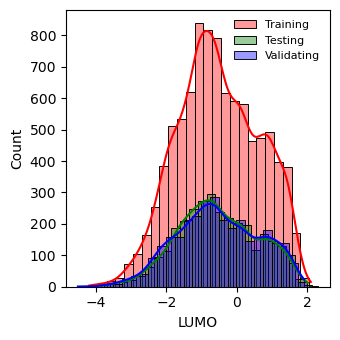

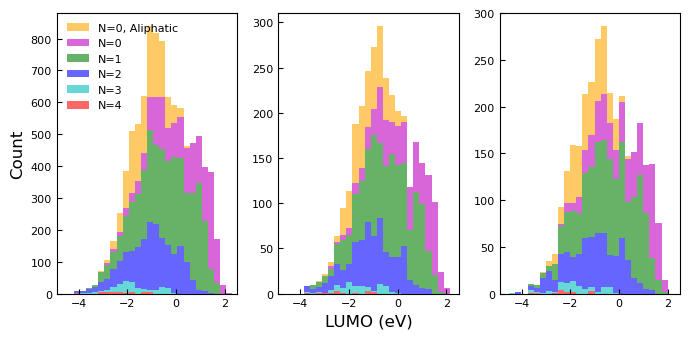

In [11]:
# The order is: df_pnl, df_qm9, df_qm9_N_1, df_qm9_N_2, df_qm9_N_3, df_qm9_N_4
use_index = [0,1,2,3,4,5] # loop which subsets
all_prop = []  
for i in use_index:
    X_prop = data_prop[i][0]
    Y_prop = data_prop[i][1]
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=4321)
    data = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    all_prop.append( data )
    
df_prop = {}  ## All together 
for k in all_prop[0].keys():  ## loop x_train,xtest,...
    df = pd.concat( [ data[k] for data in all_prop ] ,axis=0 )
    df_prop[k] = df

fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)
#df_prop['y_val'].plot(kind='bar', stacked=False, x='type', y='LUMO', ax=axs)
sns.histplot(df_prop['y_train']['LUMO'],  kde=True, color='r', alpha=0.4, label='Training', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='g', alpha=0.4, label='Testing', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='b', alpha=0.4, label='Validating', binwidth=0.25, ax=axs)
axs.legend(fontsize=8, frameon=False)
plt.show()

colors = ['orange','m','g','b','c','r']
fig, axs = plt.subplots(1,3,figsize=(7,3.5),tight_layout=True,dpi=100)
sns.histplot(df_prop['y_train'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[0], x="LUMO", hue="type", element="step", legend=True, multiple="stack")
sns.histplot(df_prop['y_test'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[1], x="LUMO", hue="type", element="step", legend=False, multiple="stack")
sns.histplot(df_prop['y_val'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=0.25, ax=axs[2], x="LUMO", hue="type", element="step", legend=False, multiple="stack")
legend = axs[0].get_legend()
handles = legend.legendHandles
#legend.remove()
axs[0].legend(handles, ['N=0, Aliphatic','N=0','N=1','N=2','N=3','N=4'], fontsize=8, frameon=False, loc=2)
for n in range(3):
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_xticks( [] )
    axs[n].set_xlim((-4.9,2.5))
    axs[n].set_ylim(bottom=0)
    axs[n].tick_params(direction='in',labelsize=8)
    #axs[n].legend_.remove()
axs[1].set_xlabel('LUMO (eV)', fontsize=12)
axs[0].set_ylabel('Count', fontsize=12)
plt.show()

#df_prop_std = standard_dataset(df_prop)
#df_prop = df_prop_std
#print( df_prop.keys() )

>1, train: 0.765, test: 0.764
>2, train: 0.875, test: 0.864
>3, train: 0.924, test: 0.908
>4, train: 0.950, test: 0.932
>5, train: 0.966, test: 0.946
>6, train: 0.970, test: 0.952
>7, train: 0.974, test: 0.955
>8, train: 0.974, test: 0.956
>9, train: 0.975, test: 0.955
>10, train: 0.975, test: 0.956
>11, train: 0.976, test: 0.957
>12, train: 0.976, test: 0.957
>13, train: 0.976, test: 0.956
>14, train: 0.976, test: 0.957
>15, train: 0.976, test: 0.957
>16, train: 0.976, test: 0.957
>17, train: 0.976, test: 0.957
>18, train: 0.976, test: 0.957
>19, train: 0.976, test: 0.957


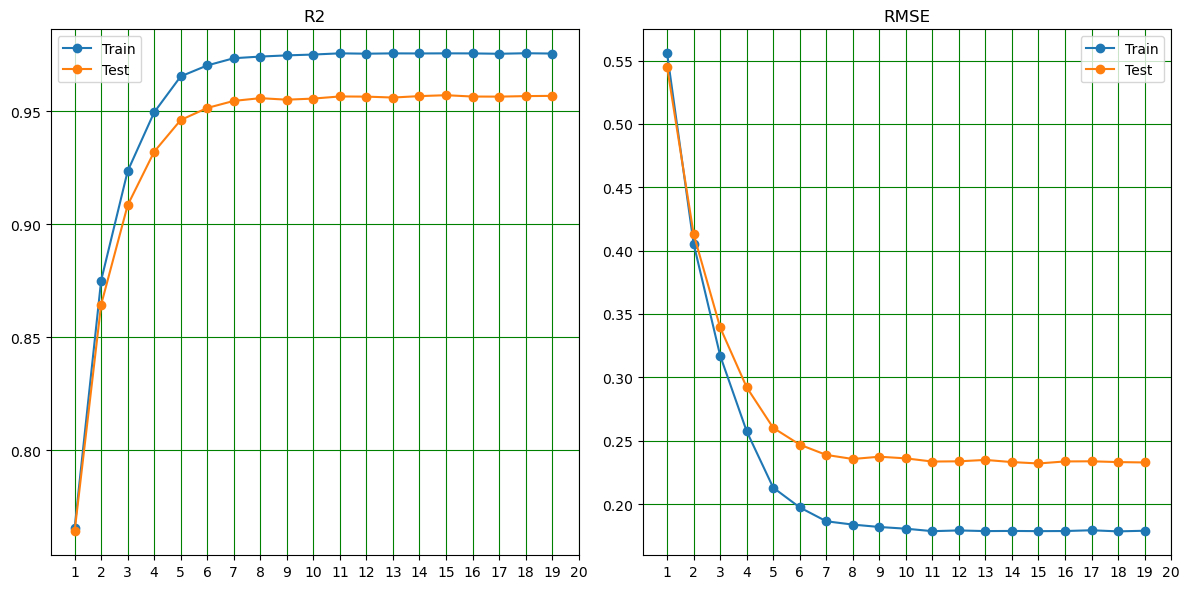

=============Done==============


In [13]:
#know_any_depth(df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], model_algorithm=RandomForestRegressor, name='Prop', max_layer=20, vb=0)
import lightgbm as lgbm
know_any_depth(df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], model_algorithm=lgbm.LGBMRegressor, name='Prop', max_layer=20, vb=-1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
================ Info =================
>>>>>> Train set (9349, 84)
R square score:  0.974

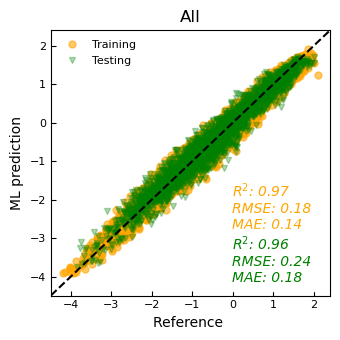

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
>>>>>> Val set (3120,)
R square score:  0.9582604606441096
RMSE, MAE: 0.23836872714675944 0.18653801698728872


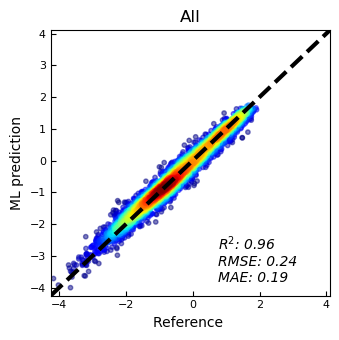

In [18]:
rf_nlayers = 8
model_all = model_any_fit( rf_nlayers, df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], model_algorithm=lgbm.LGBMRegressor, vb=0, name='All' )
score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='All')

### Finalize ML model, train and save

Train, Test, Val sizes are:  (1549, 84) (517, 84) (517, 84)
Train, Test, Val sizes are:  (2028, 84) (677, 84) (677, 84)
Train, Test, Val sizes are:  (3672, 84) (1224, 84) (1224, 84)
Train, Test, Val sizes are:  (1848, 84) (616, 84) (616, 84)
Train, Test, Val sizes are:  (213, 84) (72, 84) (72, 84)
Train, Test, Val sizes are:  (39, 84) (14, 84) (14, 84)


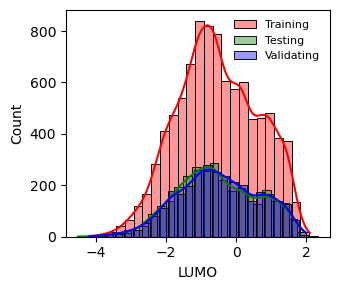

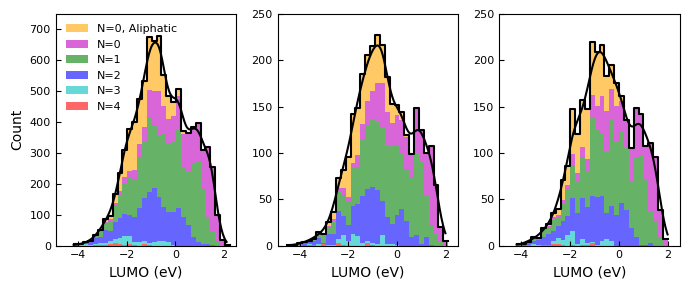

In [14]:
# The order is: df_pnl, df_qm9, df_qm9_N_1, df_qm9_N_2, df_qm9_N_3, df_qm9_N_4
use_index = [0,1,2,3,4,5] # loop which subsets
all_prop = []  
for i in use_index:
    X_prop = data_prop[i][0]
    Y_prop = data_prop[i][1]
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=20)
    data = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    all_prop.append( data )
    
df_prop = {}  ## All together 
for k in all_prop[0].keys():  ## loop x_train,xtest,...
    df = pd.concat( [ data[k] for data in all_prop ] ,axis=0 )
    df_prop[k] = df

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)
sns.histplot(df_prop['y_train']['LUMO'], kde=True, color='r', alpha=0.4, label='Training', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='g', alpha=0.4, label='Testing', binwidth=0.25, ax=axs)
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='b', alpha=0.4, label='Validating', binwidth=0.25, ax=axs)
axs.legend(fontsize=8, frameon=False)
plt.savefig("spliting.png", dpi=800)      
plt.show()

colors = ['orange','m','g','b','c','r']
fig, axs = plt.subplots(1,3,figsize=(7,3),tight_layout=True,dpi=100)
bw = 0.2
sns.histplot(df_prop['y_train']['LUMO'], kde=True, color='k', alpha=1, binwidth=bw, ax=axs[0], legend=False, fill=False, element="step")
sns.histplot(df_prop['y_test']['LUMO'],  kde=True, color='k', alpha=1, binwidth=bw, ax=axs[1], legend=False, fill=False, element="step")
sns.histplot(df_prop['y_val']['LUMO'],   kde=True, color='k', alpha=1, binwidth=bw, ax=axs[2], legend=False, fill=False, element="step")

sns.histplot(df_prop['y_train'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[0], x="LUMO", hue="type", element="step", legend=True, multiple="stack")
sns.histplot(df_prop['y_test'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[1], x="LUMO", hue="type", element="step", legend=False, multiple="stack")
sns.histplot(df_prop['y_val'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[2], x="LUMO", hue="type", element="step", legend=False, multiple="stack")
legend = axs[0].get_legend()
handles = legend.legendHandles
#legend.remove()
axs[0].legend(handles, ['N=0, Aliphatic','N=0','N=1','N=2','N=3','N=4'], fontsize=8, frameon=False, loc=2)
tit = ['Training','Testing','Validating']
for n in range(3):
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_title( tit[n], fontsize=10)
    axs[n].set_xlim((-4.9,2.5))
    axs[n].set_ylim([0,250])
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].set_xlabel('LUMO (eV)', fontsize=10)
axs[0].set_ylim([0,750])
axs[0].set_ylabel('Count', fontsize=10)
plt.savefig("spliting_detail.png", dpi=800)      
plt.show()

#df_prop_std = standard_dataset(df_prop)
#df_prop = df_prop_std
#print( df_prop.keys() )

#print(rf_nlayers)
#model_all = model_any_fit( rf_nlayers, df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], model_algorithm=lgbm.LGBMRegressor, vb=-1, name='', savefig='TrainTesting.png', axs_lim=[-4.5,2.5] )
#score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='', savefig='Validating.png', axs_lim=[-4.5,2.5] )

In [15]:
%%capture --no-display
import lightgbm

# Hyper tuning
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'num_leaves': np.arange(20, 50),
    'max_depth': np.arange(5, 20),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
random_search = RandomizedSearchCV(estimator=lightgbm.LGBMRegressor(), param_distributions=param_dist, n_iter=100, cv=3, scoring='neg_mean_absolute_error', verbose=0)
random_search.fit( df_prop['x_train'], df_prop['y_train']['LUMO'] )

display("Best hyperparameters:")
parameter = random_search.best_params_
for k,v in parameter.items():
    display(k,v)
display("Best accuracy:", random_search.best_score_, )

best_model = random_search.best_estimator_
test_accuracy = best_model.score( df_prop['x_test'], df_prop['y_test']['LUMO'] )
display("Test accuracy:", test_accuracy)

'Best hyperparameters:'

'subsample'

0.9

'num_leaves'

31

'n_estimators'

300

'max_depth'

14

'learning_rate'

0.1

'colsample_bytree'

0.8

'Best accuracy:'

-0.31688617132928926

'Test accuracy:'

0.9692754143378844

================ Info =================
>>>>>> Train set (9349, 84)
R square score:  0.9912590148934305
RMSE, MAE:  0.1069510288283022 0.08357235630895377
>>>>>> Test set (3120, 84)
R square score:  0.9692754143378844
RMSE, MAE:  0.20141369064460865 0.15466013148108113


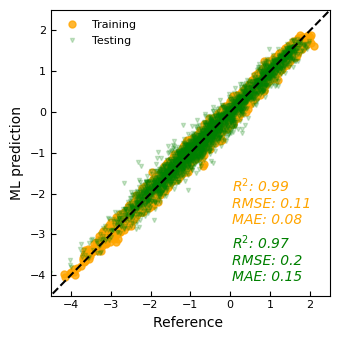

>>>>>> Val set (3120,)
R square score:  0.9693861075360736
RMSE, MAE: 0.20110242976438308 0.15472479816207918


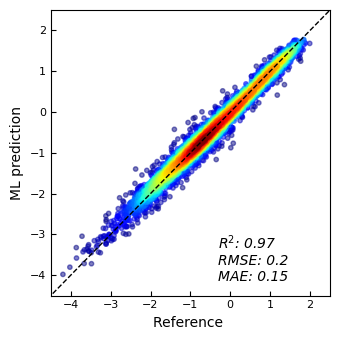

(0.97, 0.2, 0.15)

In [16]:
model_all = model_any_fit( df_prop['x_train'], df_prop['y_train']['LUMO'], df_prop['x_test'], df_prop['y_test']['LUMO'], 
                          model_algorithm=lightgbm.LGBMRegressor, 
                          vb=-1, name='', savefig='TrainTesting.png', axs_lim=[-4.5,2.5], 
                          ml_parameter=parameter) #rf_nlayers, 
score_val( df_prop['x_val'], df_prop['y_val']['LUMO'],  model_all, name='', savefig='Validating.png', axs_lim=[-4.5,2.5] )

>>>>>> Val set (517,)
R square score:  0.9222284594771631
RMSE, MAE: 0.18897066703809987 0.14774957672525788


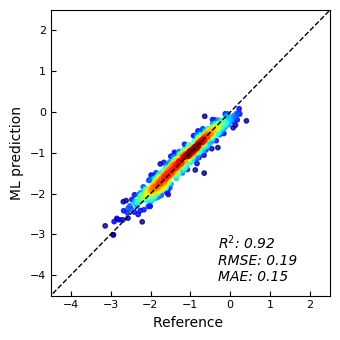

>>>>>> Val set (677,)
R square score:  0.9726626278007741
RMSE, MAE: 0.17730222340665255 0.13370041747440234


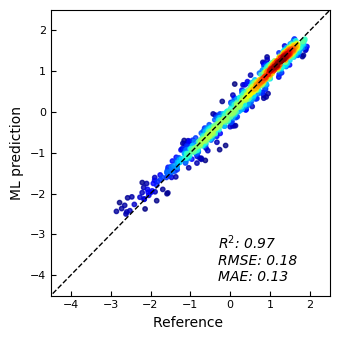

>>>>>> Val set (1224,)
R square score:  0.9722660499774982
RMSE, MAE: 0.18235053232403992 0.14110117670729855


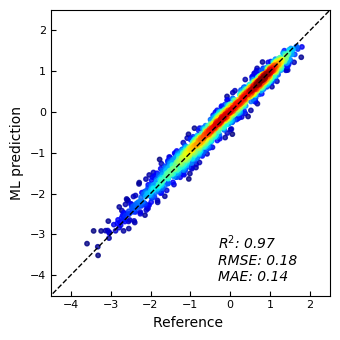

>>>>>> Val set (616,)
R square score:  0.9549361567581082
RMSE, MAE: 0.2166470506703666 0.1648267145268621


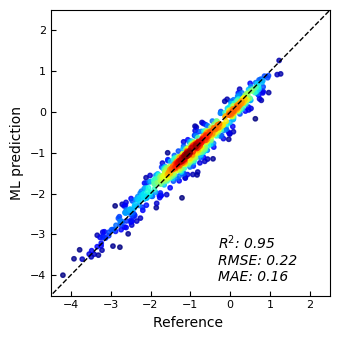

>>>>>> Val set (72,)
R square score:  0.9238197361495188
RMSE, MAE: 0.25915600866674154 0.18723043090233804


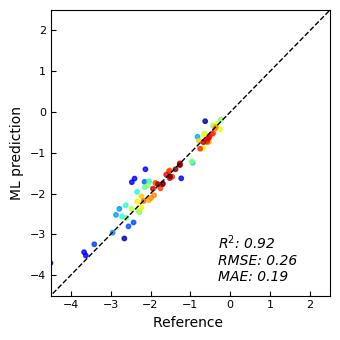

>>>>>> Val set (14,)
R square score:  0.728820644881524
RMSE, MAE: 0.3789849719374777 0.2937664981789411


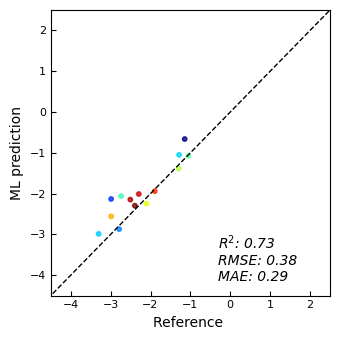

,Dataset size,R2,RMSE,MAE
0,1224,0.97,0.18,0.14
1,677,0.97,0.18,0.13
2,616,0.95,0.22,0.16
3,517,0.92,0.19,0.15
4,72,0.92,0.26,0.19
5,14,0.73,0.38,0.29


,Dataset size,R2,RMSE,MAE
0,1.10,1.10,0.10,0.16
1,0.65,1.10,0.10,0.10
2,0.60,1.02,0.30,0.29
3,0.52,0.89,0.15,0.22
4,0.15,0.89,0.50,0.48
5,0.10,0.10,1.10,1.10


In [18]:
plot_together = []
for n in use_index:
    r2,rmse,mae = score_val( all_prop[n]['x_val'], all_prop[n]['y_val']['LUMO'],  model_all, name='', axs_lim=[-4.5,2.5], alpha=0.8, savefig=f'Validating_{n}.png')
    plot_together.append( [len(all_prop[n]['x_val']),r2,rmse,mae] )
plot_together = pd.DataFrame(plot_together, columns=['Dataset size','R2','RMSE','MAE'])
plot_together = plot_together.sort_values(by='Dataset size',ascending=False).reset_index(drop=True)

df_plot = plot_together - plot_together.min()
df_plot = df_plot/df_plot.max()
df_plot += 0.1
display( plot_together, df_plot )


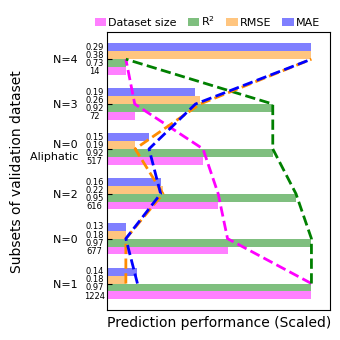

In [19]:
fig, axs = plt.subplots(1,1, figsize=(3.5,3.5),tight_layout=True)
#ax2 = axs.twinx()
colors = ['magenta','green','darkorange','b']
df_plot.plot(kind='barh', stacked=False, y=['Dataset size','R2','RMSE','MAE'], ax=axs, color=colors,
             width=0.7, alpha=0.5
            )

y = list( df_plot.index )
for i,(c,c1) in enumerate(zip(df_plot.columns,plot_together.columns)):
    axs.plot(df_plot[c],y, '--', color=colors[i], lw=2, alpha=1)
    num = [ str(s) for s in plot_together[c1]]
    for cx,cy,cm in zip(df_plot[c],y,num):
        axs.text(-0.07,cy+(i-1.55)*0.18,cm, ha='center', va='center', fontsize=6, color='k') # x=cx+0.1
    
axs.set_xlabel('Prediction performance (Scaled)',fontsize=10) ## input X name
axs.set_ylabel('Subsets of validation dataset',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8)
axs.set_yticklabels( [ 'N=0       \nAliphatic       ' if n==-1 else f'N={n}       ' for n in [1,0,2,-1,3,4]] )
axs.set_xlim([0,1.2])
axs.set_xticks( [] )

legend = axs.get_legend()
handles = legend.legendHandles
#legend.remove()
axs.legend(handles, ['Dataset size',r'R$^2$','RMSE','MAE'], fontsize=8, frameon=False, loc=0, ncol=4,
          bbox_to_anchor=(1,1.1), handlelength=1, handletextpad=0.2, columnspacing=1
          )
plt.savefig("Validating_BreakDown.png", dpi=800)      
plt.show()

In [12]:
fp_name_prop = list( df_prop['x_train'].columns )
print( fp_name_prop )

['rdk_MinEStateIndex', 'rdk_MaxAbsEStateIndex', 'rdk_MinAbsEStateIndex', 'rdk_qed', 'rdk_ExactMolWt', 'rdk_MaxPartialCharge', 'rdk_MinPartialCharge', 'rdk_FpDensityMorgan1', 'rdk_FpDensityMorgan3', 'rdk_BCUT2D_MWLOW', 'rdk_BCUT2D_CHGHI', 'rdk_BCUT2D_CHGLO', 'rdk_BCUT2D_LOGPHI', 'rdk_BCUT2D_LOGPLOW', 'rdk_BCUT2D_MRHI', 'rdk_BCUT2D_MRLOW', 'rdk_BalabanJ', 'rdk_BertzCT', 'rdk_Chi1n', 'rdk_Chi3v', 'rdk_Chi4n', 'rdk_HallKierAlpha', 'rdk_Kappa3', 'rdk_PEOE_VSA1', 'rdk_PEOE_VSA10', 'rdk_PEOE_VSA11', 'rdk_PEOE_VSA12', 'rdk_PEOE_VSA13', 'rdk_PEOE_VSA14', 'rdk_PEOE_VSA2', 'rdk_PEOE_VSA3', 'rdk_PEOE_VSA4', 'rdk_PEOE_VSA5', 'rdk_PEOE_VSA6', 'rdk_PEOE_VSA7', 'rdk_PEOE_VSA8', 'rdk_PEOE_VSA9', 'rdk_SMR_VSA1', 'rdk_SMR_VSA10', 'rdk_SMR_VSA2', 'rdk_SMR_VSA3', 'rdk_SMR_VSA4', 'rdk_SMR_VSA6', 'rdk_SMR_VSA9', 'rdk_SlogP_VSA1', 'rdk_SlogP_VSA10', 'rdk_SlogP_VSA11', 'rdk_SlogP_VSA2', 'rdk_SlogP_VSA3', 'rdk_SlogP_VSA4', 'rdk_SlogP_VSA5', 'rdk_SlogP_VSA6', 'rdk_SlogP_VSA8', 'rdk_TPSA', 'rdk_EState_VSA1', 'rdk

In [21]:
import joblib
import json

file_model = 'model_lgbm_all.pkl'
joblib.dump(model_all, file_model)

file_feature='model_lgbm_all.json'
with open(file_feature, 'w') as f1:
    json.dump(fp_name_prop, f1, indent=4)
    

## Additional script in case

In [ ]:
plt.figure(figsize=(4,3))
my_color = ['orangered','limegreen','cyan','royalblue','blueviolet','hotpink']

ndata = len(df_final['source'].value_counts())
fig, axs = plt.subplots(1,ndata+1, figsize=(4*(ndata+1),3), tight_layout=True)
axs[0].set_title('All')
for n,i in enumerate( df_final['source'].value_counts().index ):
    data = df_final[ df_final['source']==i ]['LUMO']
    print( len(data), ' data in' , i)
    sns.histplot( data=data, ax=axs[0], kde=False, binwidth=0.5, color=my_color[n])
    sns.histplot( data=data, ax=axs[n+1], kde=False, binwidth=0.5) 
    axs[n+1].set_title(i)
plt.show()

In [19]:
def has_substructure(smi, sub_struct=None):
    if sub_struct is None:
        sub_struct = ['C=CC=C']
    mol = Chem.MolFromSmiles(smi) 
    if mol is None:
        match = False
    else:
        mol = Chem.RemoveHs( mol )
        Chem.Kekulize(mol)
        if any([mol.HasSubstructMatch( Chem.MolFromSmiles(s) ) for s in sub_struct]):
            match = True
        else:
            match = False
    return match

def has_radical(smi):
    contains_radical = False
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        contains_radical = True
    else:
        if any([True if atom.GetNumRadicalElectrons()>0 else False for atom in mol.GetAtoms() ]):
            contains_radical = True
        
    return contains_radical

def has_diene_pattern(df, pattern='C=CC=C', smiles_col='SMILES'):
    new_col = 'SMILES_pattern_'+pattern
    match_smi = [ has_substructure(s, sub_struct=[pattern]) for s in df[smiles_col] ]
    df[new_col] = match_smi
    display( 'Match results: ', pattern, np.sum(match_smi) )

# Screening using ML

In [3]:
import joblib
import json

file_model = 'model_lgbm_all.pkl'
model_all = joblib.load(file_model)

file_feature='model_lgbm_all.json'
with open(file_feature, 'r') as f1:
    fp_name_prop = json.load(f1)

print( fp_name_prop )

['rdk_MinEStateIndex', 'rdk_MaxAbsEStateIndex', 'rdk_MinAbsEStateIndex', 'rdk_qed', 'rdk_ExactMolWt', 'rdk_MaxPartialCharge', 'rdk_MinPartialCharge', 'rdk_FpDensityMorgan1', 'rdk_FpDensityMorgan3', 'rdk_BCUT2D_MWLOW', 'rdk_BCUT2D_CHGHI', 'rdk_BCUT2D_CHGLO', 'rdk_BCUT2D_LOGPHI', 'rdk_BCUT2D_LOGPLOW', 'rdk_BCUT2D_MRHI', 'rdk_BCUT2D_MRLOW', 'rdk_BalabanJ', 'rdk_BertzCT', 'rdk_Chi1n', 'rdk_Chi3v', 'rdk_Chi4n', 'rdk_HallKierAlpha', 'rdk_Kappa3', 'rdk_PEOE_VSA1', 'rdk_PEOE_VSA10', 'rdk_PEOE_VSA11', 'rdk_PEOE_VSA12', 'rdk_PEOE_VSA13', 'rdk_PEOE_VSA14', 'rdk_PEOE_VSA2', 'rdk_PEOE_VSA3', 'rdk_PEOE_VSA4', 'rdk_PEOE_VSA5', 'rdk_PEOE_VSA6', 'rdk_PEOE_VSA7', 'rdk_PEOE_VSA8', 'rdk_PEOE_VSA9', 'rdk_SMR_VSA1', 'rdk_SMR_VSA10', 'rdk_SMR_VSA2', 'rdk_SMR_VSA3', 'rdk_SMR_VSA4', 'rdk_SMR_VSA6', 'rdk_SMR_VSA9', 'rdk_SlogP_VSA1', 'rdk_SlogP_VSA10', 'rdk_SlogP_VSA11', 'rdk_SlogP_VSA2', 'rdk_SlogP_VSA3', 'rdk_SlogP_VSA4', 'rdk_SlogP_VSA5', 'rdk_SlogP_VSA6', 'rdk_SlogP_VSA8', 'rdk_TPSA', 'rdk_EState_VSA1', 'rdk

In [4]:
## Make prdiction on  new data point
### pubchem, rdkprop, padelpy
from padelpy import from_smiles

def predict_padelpy(smi, fp_name, model, output_padelpy_descriptor=False, output_pubchem_fingerprint=True):
    """
    The default is to output pubchem fp and not padel descriptor
    """
    fp = from_smiles(smi, 
                     fingerprints=output_pubchem_fingerprint, 
                     descriptors=output_padelpy_descriptor
                    )
    if isinstance(smi, list):
        fp_col = list(fp[0].keys())
        fp_data = [list(f.values()) for f in fp ]
        df_fps = pd.DataFrame( data=fp_data, columns=fp_col )
    elif isinstance(smi, str):
        fp_col = list(fp.keys())
        fp_data = list(fp.values())
        df_fps = pd.DataFrame( data=[fp_data], columns=fp_col )
    df_fps = df_fps[fp_name]
    predict_new = model.predict(df_fps)
    return predict_new

from tqdm import tqdm
from time import sleep

def predict_rdk_prop(smi, fp_full_name, model, fp_calc=None):
    """
    smi: diene SMILES 
    fp_calc: the calculator 
    fp_name: the final fingerprint list for ML 
    model: trained model
    """
    fp_name = [ f.replace('rdk_','') for f in fp_full_name]
    if fp_calc==None:
        fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_name)
    if isinstance(smi, list):
        fp_molecule = []
        for i,s in zip( tqdm(range(len(smi))), smi ):
            sleep(0.000000001)
            fp = list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) )
            fp_molecule.append(fp)
        #fp_molecule = [list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) ) for s in smi]
        new_df = pd.DataFrame( data=fp_molecule, columns=fp_full_name )
        predict_new = model.predict(new_df)
    else:
        print('Error')
    return predict_new

def locate_func( smi, pattern='C=CC=C', pattern_ngb=[1,2,2,1] ):
    """
    return a dict: key=location, value=functionl groups
    """
    pattern = Chem.MolFromSmiles(pattern)
    mol = Chem.MolFromSmiles(smi)
    #display(mol)
    #display( mol_with_atom_index(mol) )
    atoms_in_diene = mol.GetSubstructMatches(pattern)[0]
    bonds = [ mol.GetAtomWithIdx(at).GetBonds() for at in atoms_in_diene ]
    output = {}
    dummy_atom = Chem.Atom(82)
    for ii,(at,bond,patt) in enumerate(zip(atoms_in_diene,bonds,pattern_ngb)):
        if len(bond)>patt: ## There is a func here
            func_bond = [b for b in bond if b.GetBeginAtom().GetIdx() not in atoms_in_diene or b.GetEndAtom().GetIdx() not in atoms_in_diene]
            func_bond = [ b.GetIdx() for b in func_bond]
            mol_fragments = Chem.FragmentOnBonds( mol, func_bond , addDummies=True , dummyLabels=[(0,0) for b in func_bond] )
            mol_fragments = Chem.RWMol(mol_fragments)            
            mol_fragments.ReplaceAtom(at, dummy_atom)
            mol_fragments = Chem.GetMolFrags(mol_fragments, asMols=True)
            mol_fragments = [ fragment for fragment in mol_fragments if not any(a.GetSymbol()=='Pb' for a in fragment.GetAtoms()) ]

            mol_fragments = [ Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mol_fragments]
            output[ii] = mol_fragments
    return output

### The large un-filtered functionalization

In [75]:
## Jump start with new structures
df1 = pd.read_csv( 'One_functionalized_13butadiene.csv', index_col=0) 
df2 = pd.read_csv( 'Two_functionalized_13butadiene.csv', index_col=0) 
display( df1, df2 )

,SMILES,INCHI,SMILES_pattern_C=CC=C,SMILES_pattern_N=CC=C,SMILES_pattern_C=NC=C,SMILES_pattern_N=NC=C,SMILES_pattern_N=CN=C,SMILES_pattern_N=CC=N,SMILES_pattern_C=NN=C,SMILES_pattern_N=NN=C,SMILES_pattern_N=NC=N,SMILES_pattern_N=NN=N
0,C=CC(=C)N,"InChI=1S/C4H7N/c1-3-4(2)5/h3H,1-2,5H2",True,False,False,False,False,False,False,False,False,False
1,C=CC=CN,"InChI=1S/C4H7N/c1-2-3-4-5/h2-4H,1,5H2",True,False,False,False,False,False,False,False,False,False
2,C=CC=CC,"InChI=1S/C5H8/c1-3-5-4-2/h3-5H,1H2,2H3",True,False,False,False,False,False,False,False,False,False
3,C=CC(=C)C,"InChI=1S/C5H8/c1-4-5(2)3/h4H,1-2H2,3H3",True,False,False,False,False,False,False,False,False,False
4,C=CC(=C)O,"InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2",True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
607,C=CC(=C)NC(=O)O,"InChI=1S/C5H7NO2/c1-3-4(2)6-5(7)8/h3,6H,1-2H2,...",True,False,False,False,False,False,False,False,False,False
608,C=CC(=C)N=CC=N,"InChI=1S/C6H8N2/c1-3-6(2)8-5-4-7/h3-5,7H,1-2H2",True,False,True,False,False,True,False,False,False,False
609,C=CC=CN=CC=N,"InChI=1S/C6H8N2/c1-2-3-5-8-6-4-7/h2-7H,1H2",True,False,True,False,False,True,False,False,False,False
610,C=CC(=C)C(=N)C=N,"InChI=1S/C6H8N2/c1-3-5(2)6(8)4-7/h3-4,7-8H,1-2H2",True,True,False,False,False,True,False,False,False,False


,SMILES,INCHI,SMILES_pattern_C=CC=C,SMILES_pattern_N=CC=C,SMILES_pattern_C=NC=C,SMILES_pattern_N=NC=C,SMILES_pattern_N=CN=C,SMILES_pattern_N=CC=N,SMILES_pattern_C=NN=C,SMILES_pattern_N=NN=C,SMILES_pattern_N=NC=N,SMILES_pattern_N=NN=N
0,C=CC(N)=CN,"InChI=1S/C4H8N2/c1-2-4(6)3-5/h2-3H,1,5-6H2",True,False,False,False,False,False,False,False,False,False
1,C=C(N)C=CN,"InChI=1S/C4H8N2/c1-4(6)2-3-5/h2-3H,1,5-6H2",True,False,False,False,False,False,False,False,False,False
2,C=C(N)C(=C)N,"InChI=1S/C4H8N2/c1-3(5)4(2)6/h1-2,5-6H2",True,False,False,False,False,False,False,False,False,False
3,C=C(C)C(=C)N,"InChI=1S/C5H9N/c1-4(2)5(3)6/h1,3,6H2,2H3",True,False,False,False,False,False,False,False,False,False
4,C=CC(N)=CC,"InChI=1S/C5H9N/c1-3-5(6)4-2/h3-4H,1,6H2,2H3",True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
654225,C=CC(=CC(=N)C=N)C(=N)C=N,InChI=1S/C8H10N4/c1-2-6(8(12)5-10)3-7(11)4-9/h...,True,True,False,False,False,True,False,False,False,False
654226,C=C(C=CC(=N)C=N)C(=N)C=N,InChI=1S/C8H10N4/c1-6(8(12)5-10)2-3-7(11)4-9/h...,True,True,False,False,False,True,False,False,False,False
654227,C=C(C(=C)C(=N)C=N)C(=N)C=N,InChI=1S/C8H10N4/c1-5(7(11)3-9)6(2)8(12)4-10/h...,True,True,False,False,False,True,False,False,False,False
655448,C=CC=C(C(=N)C=N)C(=N)C=N,InChI=1S/C8H10N4/c1-2-3-6(7(11)4-9)8(12)5-10/h...,True,True,False,False,False,True,False,False,False,False


In [31]:
## If needed
%%capture --no-display
patterns = ['C=CC=C','N=CC=C','C=NC=C','N=NC=C','N=CN=C','N=CC=N','C=NN=C','N=NN=C','N=NC=N','N=NN=N']
for p in patterns:
    has_diene_pattern(df1, pattern=p)
for p in patterns:
    has_diene_pattern(df2, pattern=p)
df1.to_csv( 'One_functionalized_13butadiene.csv') 
df2.to_csv( 'Two_functionalized_13butadiene.csv') 


'Match results: '

'C=CC=C'

611

'Match results: '

'N=CC=C'

56

'Match results: '

'C=NC=C'

28

'Match results: '

'N=NC=C'

18

'Match results: '

'N=CN=C'

6

'Match results: '

'N=CC=N'

4

'Match results: '

'C=NN=C'

2

'Match results: '

'N=NN=C'

4

'Match results: '

'N=NC=N'

0

'Match results: '

'N=NN=N'

2

'Match results: '

'C=CC=C'

326887

'Match results: '

'N=CC=C'

57124

'Match results: '

'C=NC=C'

29187

'Match results: '

'N=NC=C'

18877

'Match results: '

'N=CN=C'

6396

'Match results: '

'N=CC=N'

4271

'Match results: '

'C=NN=C'

2139

'Match results: '

'N=NN=C'

4271

'Match results: '

'N=NC=N'

0

'Match results: '

'N=NN=N'

2139

,SMILES,INCHI,SMILES_pattern_C=CC=C,SMILES_pattern_N=CC=C,SMILES_pattern_C=NC=C,SMILES_pattern_N=NC=C,SMILES_pattern_N=CN=C,SMILES_pattern_N=CC=N,SMILES_pattern_C=NN=C,SMILES_pattern_N=NN=C,SMILES_pattern_N=NC=N,SMILES_pattern_N=NN=N
0,C=CC(=C)N,"InChI=1S/C4H7N/c1-3-4(2)5/h3H,1-2,5H2",True,False,False,False,False,False,False,False,False,False
1,C=CC=CN,"InChI=1S/C4H7N/c1-2-3-4-5/h2-4H,1,5H2",True,False,False,False,False,False,False,False,False,False
2,C=CC=CC,"InChI=1S/C5H8/c1-3-5-4-2/h3-5H,1H2,2H3",True,False,False,False,False,False,False,False,False,False
3,C=CC(=C)C,"InChI=1S/C5H8/c1-4-5(2)3/h4H,1-2H2,3H3",True,False,False,False,False,False,False,False,False,False
4,C=CC(=C)O,"InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2",True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
607,C=CC(=C)NC(=O)O,"InChI=1S/C5H7NO2/c1-3-4(2)6-5(7)8/h3,6H,1-2H2,...",True,False,False,False,False,False,False,False,False,False
608,C=CC(=C)N=CC=N,"InChI=1S/C6H8N2/c1-3-6(2)8-5-4-7/h3-5,7H,1-2H2",True,False,True,False,False,True,False,False,False,False
609,C=CC=CN=CC=N,"InChI=1S/C6H8N2/c1-2-3-5-8-6-4-7/h2-7H,1H2",True,False,True,False,False,True,False,False,False,False
610,C=CC(=C)C(=N)C=N,"InChI=1S/C6H8N2/c1-3-5(2)6(8)4-7/h3-4,7-8H,1-2H2",True,True,False,False,False,True,False,False,False,False


,SMILES,INCHI,SMILES_pattern_C=CC=C,SMILES_pattern_N=CC=C,SMILES_pattern_C=NC=C,SMILES_pattern_N=NC=C,SMILES_pattern_N=CN=C,SMILES_pattern_N=CC=N,SMILES_pattern_C=NN=C,SMILES_pattern_N=NN=C,SMILES_pattern_N=NC=N,SMILES_pattern_N=NN=N
0,C=CC(N)=CN,"InChI=1S/C4H8N2/c1-2-4(6)3-5/h2-3H,1,5-6H2",True,False,False,False,False,False,False,False,False,False
1,C=C(N)C=CN,"InChI=1S/C4H8N2/c1-4(6)2-3-5/h2-3H,1,5-6H2",True,False,False,False,False,False,False,False,False,False
2,C=C(N)C(=C)N,"InChI=1S/C4H8N2/c1-3(5)4(2)6/h1-2,5-6H2",True,False,False,False,False,False,False,False,False,False
3,C=C(C)C(=C)N,"InChI=1S/C5H9N/c1-4(2)5(3)6/h1,3,6H2,2H3",True,False,False,False,False,False,False,False,False,False
4,C=CC(N)=CC,"InChI=1S/C5H9N/c1-3-5(6)4-2/h3-4H,1,6H2,2H3",True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
654225,C=CC(=CC(=N)C=N)C(=N)C=N,InChI=1S/C8H10N4/c1-2-6(8(12)5-10)3-7(11)4-9/h...,True,True,False,False,False,True,False,False,False,False
654226,C=C(C=CC(=N)C=N)C(=N)C=N,InChI=1S/C8H10N4/c1-6(8(12)5-10)2-3-7(11)4-9/h...,True,True,False,False,False,True,False,False,False,False
654227,C=C(C(=C)C(=N)C=N)C(=N)C=N,InChI=1S/C8H10N4/c1-5(7(11)3-9)6(2)8(12)4-10/h...,True,True,False,False,False,True,False,False,False,False
655448,C=CC=C(C(=N)C=N)C(=N)C=N,InChI=1S/C8H10N4/c1-2-3-6(7(11)4-9)8(12)5-10/h...,True,True,False,False,False,True,False,False,False,False


In [76]:
patterns_col = [ c for c in df1.columns if 'SMILES_pattern_' in c ]
pattern_yes = ['SMILES_pattern_C=CC=C']
pattern_no = [p for p in patterns_col if p not in pattern_yes]

mask1 = np.any( df1[pattern_yes]==True, axis=1)
mask2 = np.all( df1[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)
df1_filter = df1[mask_keep]

mask1 = np.any( df2[pattern_yes]==True, axis=1)
mask2 = np.all( df2[pattern_no]==False, axis=1)
mask_keep = np.all([mask1,mask2], axis=0)
df2_filter = df2[mask_keep]

display( df1_filter, df2_filter )

,SMILES,INCHI,SMILES_pattern_C=CC=C,SMILES_pattern_N=CC=C,SMILES_pattern_C=NC=C,SMILES_pattern_N=NC=C,SMILES_pattern_N=CN=C,SMILES_pattern_N=CC=N,SMILES_pattern_C=NN=C,SMILES_pattern_N=NN=C,SMILES_pattern_N=NC=N,SMILES_pattern_N=NN=N
0,C=CC(=C)N,"InChI=1S/C4H7N/c1-3-4(2)5/h3H,1-2,5H2",True,False,False,False,False,False,False,False,False,False
1,C=CC=CN,"InChI=1S/C4H7N/c1-2-3-4-5/h2-4H,1,5H2",True,False,False,False,False,False,False,False,False,False
2,C=CC=CC,"InChI=1S/C5H8/c1-3-5-4-2/h3-5H,1H2,2H3",True,False,False,False,False,False,False,False,False,False
3,C=CC(=C)C,"InChI=1S/C5H8/c1-4-5(2)3/h4H,1-2H2,3H3",True,False,False,False,False,False,False,False,False,False
4,C=CC(=C)O,"InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2",True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
603,C=CC(=C)NNN=C,"InChI=1S/C5H9N3/c1-4-5(2)7-8-6-3/h4,7-8H,1-3H2",True,False,False,False,False,False,False,False,False,False
604,C=CC(=C)N(N)N=C,"InChI=1S/C5H9N3/c1-4-5(2)8(6)7-3/h4H,1-3,6H2",True,False,False,False,False,False,False,False,False,False
605,C=CC=CN(N)N=C,"InChI=1S/C5H9N3/c1-3-4-5-8(6)7-2/h3-5H,1-2,6H2",True,False,False,False,False,False,False,False,False,False
606,C=CC=CNC(=O)O,"InChI=1S/C5H7NO2/c1-2-3-4-6-5(7)8/h2-4,6H,1H2,...",True,False,False,False,False,False,False,False,False,False


,SMILES,INCHI,SMILES_pattern_C=CC=C,SMILES_pattern_N=CC=C,SMILES_pattern_C=NC=C,SMILES_pattern_N=NC=C,SMILES_pattern_N=CN=C,SMILES_pattern_N=CC=N,SMILES_pattern_C=NN=C,SMILES_pattern_N=NN=C,SMILES_pattern_N=NC=N,SMILES_pattern_N=NN=N
0,C=CC(N)=CN,"InChI=1S/C4H8N2/c1-2-4(6)3-5/h2-3H,1,5-6H2",True,False,False,False,False,False,False,False,False,False
1,C=C(N)C=CN,"InChI=1S/C4H8N2/c1-4(6)2-3-5/h2-3H,1,5-6H2",True,False,False,False,False,False,False,False,False,False
2,C=C(N)C(=C)N,"InChI=1S/C4H8N2/c1-3(5)4(2)6/h1-2,5-6H2",True,False,False,False,False,False,False,False,False,False
3,C=C(C)C(=C)N,"InChI=1S/C5H9N/c1-4(2)5(3)6/h1,3,6H2,2H3",True,False,False,False,False,False,False,False,False,False
4,C=CC(N)=CC,"InChI=1S/C5H9N/c1-3-5(6)4-2/h3-4H,1,6H2,2H3",True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
650238,C=CC(=CNC(=O)O)NC(=O)O,InChI=1S/C6H8N2O4/c1-2-4(8-6(11)12)3-7-5(9)10/...,True,False,False,False,False,False,False,False,False,False
650239,C=C(C=CNC(=O)O)NC(=O)O,InChI=1S/C6H8N2O4/c1-4(8-6(11)12)2-3-7-5(9)10/...,True,False,False,False,False,False,False,False,False,False
650240,O=C(O)NC=CC=CNC(=O)O,InChI=1S/C6H8N2O4/c9-5(10)7-3-1-2-4-8-6(11)12/...,True,False,False,False,False,False,False,False,False,False
650241,C=CC=C(NC(=O)O)NC(=O)O,InChI=1S/C6H8N2O4/c1-2-3-4(7-5(9)10)8-6(11)12/...,True,False,False,False,False,False,False,False,False,False


In [ ]:
df1_filter.to_csv('Predicted_cccc_pnl_one_func.csv')
df2_filter.to_csv('Predicted_cccc_pnl_two_func.csv')

### Common functional group list

In [13]:
## The 1,3-butadiene 
df1_a = pd.read_csv( 'ShortList_One_functionalized_13butadiene.csv', index_col=0) 
df2_a = pd.read_csv( 'ShortList_Two_functionalized_13butadiene.csv', index_col=0) 
df3_a = pd.read_csv( 'ShortList_Three_functionalized_13butadiene.csv', index_col=0) 
df4_a = pd.read_csv( 'ShortList_Four_functionalized_13butadiene.csv', index_col=0) 
print( len(df1_a),len(df2_a),len(df3_a),len(df4_a) )

df0_n = pd.read_csv( 'ShortList_None_functionalized_Nring.csv', index_col=0) 
df1_n = pd.read_csv( 'ShortList_One_functionalized_Nring.csv', index_col=0)  
df2_n = pd.read_csv( 'ShortList_Two_functionalized_Nring.csv', index_col=0)  
df3_n = pd.read_csv( 'ShortList_Three_functionalized_Nring.csv', index_col=0) 
df4_n = pd.read_csv( 'ShortList_Four_functionalized_Nring.csv', index_col=0) 
print( len(df0_n),len(df1_n),len(df2_n),len(df3_n),len(df4_n) )

print( 'Total: ', len(df1_a)+len(df2_a)+len(df3_a)+len(df4_a)  +  len(df0_n)+len(df1_n)+len(df2_n)+len(df3_n)+len(df4_n) )
display( df1_a.head(), df0_n.head() )

42 1554 32865 429870
58 2204 42420 485989 3531654
Total:  4526656


,SMILES,INCHI
0,C=CC=CO,"InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2"
1,C=CC(=C)O,"InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2"
2,C=CC(=C)NC,"InChI=1S/C5H9N/c1-4-5(2)6-3/h4,6H,1-2H2,3H3"
3,C=CC=CNC,"InChI=1S/C5H9N/c1-3-4-5-6-2/h3-6H,1H2,2H3"
4,C=CC(=C)N(C)C,"InChI=1S/C6H11N/c1-5-6(2)7(3)4/h5H,1-2H2,3-4H3"


,SMILES,type,INCHI
0,C1=NN=CC1,0,"InChI=1S/C3H4N2/c1-2-4-5-3-1/h2-3H,1H2"
1,C1=NC=NC1,0,"InChI=1S/C3H4N2/c1-2-5-3-4-1/h1,3H,2H2"
2,C1=NCN=C1,0,"InChI=1S/C3H4N2/c1-2-5-3-4-1/h1-2H,3H2"
3,C1=NN=NC1,0,"InChI=1S/C2H3N3/c1-2-4-5-3-1/h1H,2H2"
4,C1=NCN=N1,0,"InChI=1S/C2H3N3/c1-3-2-5-4-1/h1H,2H2"


In [ ]:
from itertools import chain
df1_filter = df1_a[[ not len( list(chain(*locate_func(smi=s).values())) )!=1 for s in df1_a['SMILES'] ]]
df2_filter = df2_a[[ not len( list(chain(*locate_func(smi=s).values())) )!=2 for s in df2_a['SMILES'] ]]
df3_filter = df3_a[[ not len( list(chain(*locate_func(smi=s).values())) )!=3 for s in df3_a['SMILES'] ]]
df4_filter = df4_a[[ not len( list(chain(*locate_func(smi=s).values())) )!=4 for s in df4_a['SMILES'] ]]
display( len(df1_filter),len(df2_filter),len(df3_filter),len(df4_filter) )

In [14]:
df1_a['type'] = 11
df2_a['type'] = 12
df3_a['type'] = 13
df4_a['type'] = 14
df0_a = pd.DataFrame( [['C=CC=C','None',10]], columns=['SMILES','INCHI','type'] )
df_all= pd.concat( [ df0_a,df1_a,df2_a,df3_a,df4_a,  df0_n,df1_n,df2_n,df3_n,df4_n ], axis=0 )
display( df_all.shape )
df_all = df_all.drop_duplicates(subset=['INCHI'], keep='first', inplace=False)

df_all.to_csv('New_all_dienes.csv')
df_all

(4526657, 3)

,SMILES,INCHI,type
0,C=CC=C,None,10
0,C=CC=CO,"InChI=1S/C4H6O/c1-2-3-4-5/h2-5H,1H2",11
1,C=CC(=C)O,"InChI=1S/C4H6O/c1-3-4(2)5/h3,5H,1-2H2",11
2,C=CC(=C)NC,"InChI=1S/C5H9N/c1-4-5(2)6-3/h4,6H,1-2H2,3H3",11
3,C=CC=CNC,"InChI=1S/C5H9N/c1-3-4-5-6-2/h3-6H,1H2,2H3",11
...,...,...,...
305608,N=NC1(N=N)N=C(C(N)=O)C(C(N)=O)=NC1=O,InChI=1S/C6H6N8O3/c7-3(15)1-2(4(8)16)12-6(13-9...,6
305609,N=NC1=NC(N=N)(C(N)=O)C(=O)N=C1C(N)=O,"InChI=1S/C6H6N8O3/c7-2(15)1-3(13-9)12-6(14-10,...",6
305610,N=NC1(C(N)=O)N=C(C(N)=O)C(C(N)=O)=NC1=O,InChI=1S/C7H7N7O4/c8-3(15)1-2(4(9)16)13-7(14-1...,6
305611,N=NC1=NC(C(N)=O)(C(N)=O)C(=O)N=C1C(N)=O,InChI=1S/C7H7N7O4/c8-2(15)1-3(14-11)13-7(4(9)1...,6


In [15]:
df_rings = pd.concat( [df['type'].value_counts() for df in [df0_n,df1_n,df2_n,df3_n,df4_n]], axis=1 ).sort_values(by='type',ascending=True).T
df_rings.columns = ['Ring=5','Ring=5 with O','Ring=5 with C=O','Ring=6','Ring=6 C-C','Ring=6 with O','Ring=6 with C=O','Ring=6 with both C=O and O']  ## The name of each type
df_rings

,Ring=5,Ring=5 with O,Ring=5 with C=O,Ring=6,Ring=6 C-C,Ring=6 with O,Ring=6 with C=O,Ring=6 with both C=O and O
count,6.0,6.0,6.0,8.0,6.0,10.0,6.0,10.0
count,252.0,126.0,125.0,294.0,315.0,504.0,294.0,294.0
count,4935.0,903.0,882.0,6279.0,10290.0,10689.0,6237.0,2205.0
count,48069.0,NaN,NaN,62629.0,194481.0,114219.0,66591.0,NaN
count,208593.0,NaN,NaN,248283.0,2259810.0,509355.0,305613.0,NaN


,Aliphatic,Ring 5,Ring 5 with O,Ring 5 with =O,Ring 6,Ring 6 with C-C,Ring 6 with O,Ring 6 with =O,Ring 6 with both =O and O
0,1,6.0,6.0,6.0,8.0,6.0,10.0,6.0,10.0
1,42,252.0,126.0,125.0,294.0,315.0,504.0,294.0,294.0
2,1554,4935.0,903.0,882.0,6279.0,10290.0,10689.0,6237.0,2205.0
3,32865,48069.0,NaN,NaN,62629.0,194481.0,114219.0,66591.0,NaN
4,429870,208593.0,NaN,NaN,248283.0,2259810.0,509355.0,305613.0,NaN


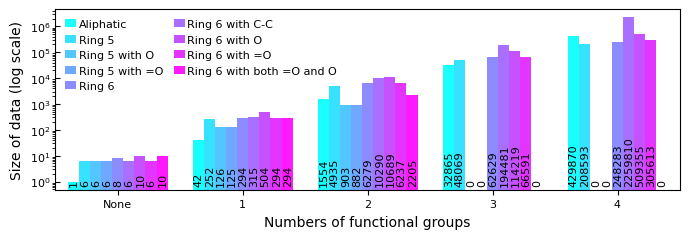

In [16]:
df_butad = pd.DataFrame([len(df0_a),len(df1_a),len(df2_a),len(df3_a),len(df4_a)], columns=['Aliphatic'])   
df_butad.index = [0,1,2,3,4]
#display( df_butad )

ring_names = ['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
df_rings = pd.concat( [df['type'].value_counts() for df in [df0_n,df1_n,df2_n,df3_n,df4_n]], axis=1 ).sort_values(by='type',ascending=True).T
df_rings.columns = ring_names  ## The name of each type
df_rings.index = [0,1,2,3,4]   ## The num of functional groups 
#display( df_rings )  

df_plot = pd.concat([df_butad,df_rings], axis=1, join='outer').sort_index()
display( df_plot )  

fig, axs = plt.subplots(1,1,figsize=(7,2.5),tight_layout=True,dpi=100)

#colors = ['magenta','green','darkorange','b','r']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(0, 1, 9))

df_plot.plot(kind='bar', stacked=False, y=['Aliphatic']+ring_names, ax=axs, color=colors,
             width=0.8, alpha=0.9)
#for ii,container in enumerate(axs.containers):
#    container.datavalues[0]=-1
#    axs.bar_label(container, rotation=90, fontsize=8, padding=-30 ) #label_type='center')
for rect in axs.patches:
    x = rect.get_x()
    y = rect.get_height()
    axs.text(x+0.01,0.7,str(int(y)), ha='left', va='bottom', fontsize=8, color='k', rotation=90) # x=cx+0.1
    
axs.set_xlabel('Numbers of functional groups',fontsize=10) ## input X name
axs.set_ylabel('Size of data (log scale)',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8, axis='y')
axs.set_xticklabels( ['None','1','2','3','4'], rotation=0, fontsize=8)
axs.set_xlim([-0.5,4.5])
#axs.set_xticks( [] )
axs.legend(labels=['Aliphatic']+ring_names, fontsize=8, frameon=False, ncol=2, handlelength=1, handletextpad=0.2, columnspacing=1)
plt.yscale('log')

plt.savefig("poplation.png", dpi=800)  
plt.show()


### Prediction

In [47]:
s = 'C=CC=C'
fp_name = [ f.replace('rdk_','') for f in fp_name_prop]
fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_name)
fp = list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) )
df = pd.DataFrame( data=[fp], columns=fp_name_prop )

predict_new = model_all.predict(df)
predict_new

array([0.05447273])

In [ ]:
### This could take a long time with many data, so passed it to HPC and read results here

## The rdk fp
prediction1 = predict_rdk_prop( list(df_all['SMILES']), fp_name_prop, model_all)
df_all['LUMO_predicted'] = prediction1
df_all.to_csv('New_all_dienes_PredLUMO.csv')
df_all
#df_all = pd.read_csv( 'New_all_dienes_PredLUMO.csv', index_col=0) 
#df_all = df_all.sort_values(by='LUMO_predicted',ascending=True)
#df_all

In [48]:
df_pnl = pd.read_csv('df_final_pnl_cccc.csv', index_col=0)
df_qm9 = pd.read_csv('df_final_qm9_cccc.csv', index_col=0)
df_qm9_N = pd.read_csv('df_final_qm9_n_diene.csv', index_col=0)
df_pnl['type'] =90
df_qm9['type'] =91
df_qm9_N['type'] =92
df_old = pd.concat( [df_pnl,df_qm9,df_qm9_N], axis=0 )
df_old = df_old[['SMILES','type','LUMO']]
df_old.drop_duplicates(subset='SMILES', inplace=True, keep='first')

prediction1 = predict_rdk_prop( list(df_old['SMILES']), fp_name_prop, model_all)
df_old['LUMO_predicted'] = prediction1
df_old = df_old.sort_values(by='LUMO_predicted',ascending=True)

df_old.to_csv('Old_all_dienes_PredLUMO.csv')

df_old

100%|██████████| 15589/15589 [04:09<00:00, 62.37it/s]


,SMILES,type,LUMO,LUMO_predicted
21191,O=C(C#N)n1nnnn1,92,-4.149632,-4.069829
21290,O=c1oncnc1C#N,92,-4.168679,-4.055188
21184,O=C(C#N)c1nonn1,92,-3.912899,-4.026381
21284,O=c1oncc(n1)C#N,92,-4.195890,-3.999700
21293,O=c1onnc(c1)C#N,92,-4.021741,-3.984084
...,...,...,...,...
13875,CNc1c[nH]c(OC)c1,91,2.013592,1.909182
5492,COc1cc(N)c[nH]1,91,1.956449,1.909332
13888,COc1cc(OC)c[nH]1,91,1.855770,1.910297
4677,Nc1c[nH]c(O)c1,91,1.929239,1.931363


In [5]:
## Jump start with predicted values
df_new = pd.read_csv( 'New_all_dienes_PredLUMO.csv', index_col=0).sort_values(by='LUMO_predicted',ascending=True) 
df_old = pd.read_csv( 'Old_all_dienes_PredLUMO.csv', index_col=0) 
display( df_new, df_old )

,SMILES,INCHI,type,LUMO_predicted
286,N#Cc1nnoc(=O)n1,InChI=1S/C3N4O2/c4-1-2-5-3(8)9-7-6-2,7,-4.093544
153,N#Cc1ncnoc1=O,InChI=1S/C4HN3O2/c5-1-3-4(8)9-7-2-6-3/h2H,7,-4.055188
244,N#Cc1nnnoc1=O,InChI=1S/C3N4O2/c4-1-2-3(8)9-7-6-5-2,7,-4.053956
195,N#Cc1cnoc(=O)n1,InChI=1S/C4HN3O2/c5-1-3-2-6-9-4(8)7-3/h2H,7,-3.999700
68,N#Cc1cc(=O)onn1,InChI=1S/C4HN3O2/c5-2-3-1-4(8)9-7-6-3/h1H,7,-3.984084
...,...,...,...,...
22,CNc1nnc(N(C)C)o1,InChI=1S/C5H10N4O/c1-6-4-7-8-5(10-4)9(2)3/h1-3...,1,0.998175
18700,Nc1cc(N)nc(O)n1,"InChI=1S/C4H6N4O/c5-2-1-3(6)8-4(9)7-2/h1H,(H5,...",3,1.024298
61089,CNc1nc(NC)nc(NC)n1,InChI=1S/C6H12N6/c1-7-4-10-5(8-2)12-6(9-3)11-4...,3,1.053329
21,CNc1nnc(NC)o1,"InChI=1S/C4H8N4O/c1-5-3-7-8-4(6-2)9-3/h1-2H3,(...",1,1.058551


,SMILES,type,LUMO,LUMO_predicted
21191,O=C(C#N)n1nnnn1,92,-4.149632,-4.069829
21290,O=c1oncnc1C#N,92,-4.168679,-4.055188
21184,O=C(C#N)c1nonn1,92,-3.912899,-4.026381
21284,O=c1oncc(n1)C#N,92,-4.195890,-3.999700
21293,O=c1onnc(c1)C#N,92,-4.021741,-3.984084
...,...,...,...,...
13875,CNc1c[nH]c(OC)c1,91,2.013592,1.909182
5492,COc1cc(N)c[nH]1,91,1.956449,1.909332
13888,COc1cc(OC)c[nH]1,91,1.855770,1.910297
4677,Nc1c[nH]c(O)c1,91,1.929239,1.931363


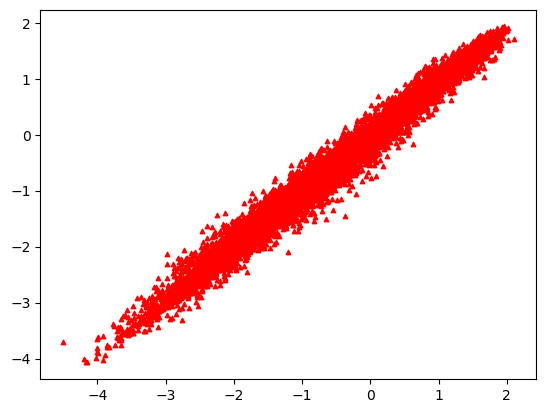

In [6]:
#sns.scatterplot(data=df_old, x=, y=)
x,y = df_old["LUMO"], df_old["LUMO_predicted"]
plt.scatter(x,y, s=10, marker='^', c='r')

In [7]:
## New:: 10,11,12,13,14 = aliphatic, 0,7=['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
## Old:  90=PNL, 91=QM9 ring without N, 92=QM9 ring with N
display( df_new['type'].value_counts().sort_index(ascending=False), df_old['type'].value_counts().sort_index(ascending=False) )

type
14     429870
13      32865
12       1554
11         42
10          1
7        2509
6      378741
5      634777
4     2464902
3      317493
2        1013
1        1035
0      261855
Name: count, dtype: int64

type
92    9624
91    3382
90    2583
Name: count, dtype: int64

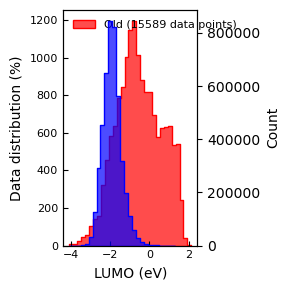

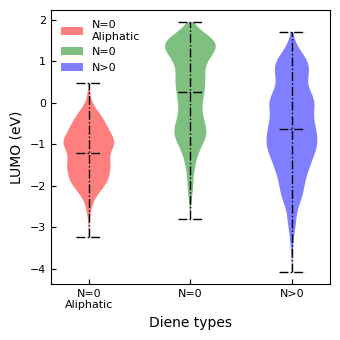

In [8]:
## New:: 10,11,12,13,14 = aliphatic, 0-7=['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
## Old:  90=PNL, 91=QM9 ring without N, 92=QM9 ring with N

fig, axs = plt.subplots(1,1,figsize=(3.,3),tight_layout=True,dpi=100)
axt = axs.twinx()
#sns.histplot(df_pnl, x='LUMO', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.9, fill=True, color='k',label=f'DFT ({len(df_pnl)} data points)', stat='percent')
sns.histplot(df_old, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.7, fill=True, color='r',label=f'Old ({len(df_old)} data points)',)# stat='percent')
sns.histplot(df_new, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axt, element="step", alpha=0.7, fill=True, color='b',label=f'New ({len(df_new)} data points)',)# stat='percent')
axs.set_ylabel('Data distribution (%)', fontsize=10)
axs.set_xlabel('LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
axs.legend(fontsize=8, frameon=False, loc=2)
#axs.set_ylim(top=18.5)
plt.show()
#plt.savefig("ML_prediction_compare_old_new.png", dpi=800)

fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=100)

names_new = ['Aliphatic']+['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(0, 1, len(names_new)))
colors = ['r','g','b']
data_plot_old = [ df_old[df_old['type']==n] for n in [90,91,92] ]
data_plot_new = [ df_new[df_new['type']>9] ] + [ df_new[df_new['type']==n] for n in [0,1,2,3,4,5,6,7] ]
#sns.histplot(df1, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.9, fill=True, color='b',label=f'Old aliphatic ({len(df1)} data points)', stat='percent')
#sns.histplot(df2, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.7, fill=True, color='y',label=f'Old ring N=0 ({len(df2)} data points)', stat='percent')
#sns.histplot(df3, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.5, fill=True, color='g',label=f'Old ring N>0 ({len(df3)} data points)', stat='percent')
#sns.histplot(df4, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.3, fill=True, color='r',label=f'New aliphatic ({len(df4)} data points)', stat='percent')
#sns.histplot(df5, x='LUMO_predicted', kde=False, binwidth=0.2, ax=axs, element="step", alpha=0.2, fill=True, color='c',label=f'New ring N>0 ({len(df5)} data points)', stat='percent')
#sns.violinplot(df1, x='LUMO_predicted', y='type', ax=axs)#kde=False, binwidth=0.2,  element="step", alpha=0.2, fill=True, color='c',label=f'New ring N>0 ({len(df5)} data points)', stat='percent')
parts = axs.violinplot( [ d['LUMO_predicted'] for d in data_plot_old ], showmeans=True)
for i,p in enumerate(parts['bodies']):
    p.set_facecolor(colors[i])
    p.set_edgecolor('None')
    p.set_alpha(0.5)
    #p.set_linewidth(0.1)
for k in ['cbars','cmins','cmaxes','cmeans']:
    parts[k].set_colors('k')    
    parts[k].set_linewidth(1)
    parts[k].set_linestyles('-.')
    
axs.set_xlabel('Diene types', fontsize=10)
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
axs.set_xticks( [n+1 for n in range(len(data_plot_old)) ] ,labels=['N=0\nAliphatic','N=0','N>0'])

axs.legend(labels=['N=0\nAliphatic','N=0','N>0'], fontsize=8, frameon=False, loc=2)
#axs.set_ylim(top=25)
plt.show()


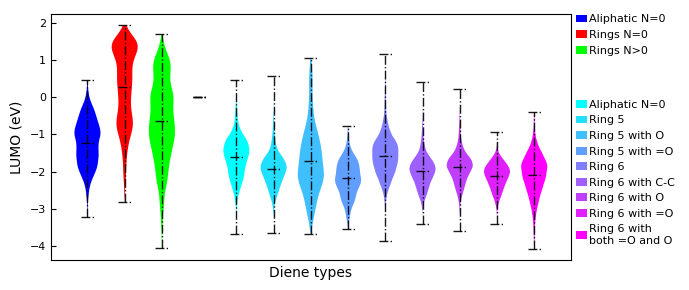

In [9]:
fig, axs = plt.subplots(1,1,figsize=(7,3),tight_layout=True,dpi=100)

data_plot_old = [ df_old[df_old['type']==n] for n in [90,91,92] ]
data_plot_new = [ df_new[df_new['type']>9] ] + [ df_new[df_new['type']==n] for n in [0,1,2,3,4,5,6,7] ]

names_new = ['Aliphatic N=0']+['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with \nboth =O and O']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(0, 1, len(names_new)))
position = [n for n in range(len(colors))]

names_new = ['Aliphatic N=0','Rings N=0','Rings N>0'] +['\n\n']+names_new
cmap = plt.get_cmap('brg')
colors = np.concatenate( (cmap(np.linspace(0, 1, 3)), [[1.0, 1.0, 1.0, 1.0]], colors), axis=0)
position = [1,2,3,4] + [p+6 for p in position]

parts = axs.violinplot( [ d['LUMO_predicted'] for d in data_plot_old ]+[[0,0]]+[ d['LUMO_predicted'] for d in data_plot_new ], 
                       showmeans=True, widths=0.7)
for i,p in enumerate(parts['bodies']):
    p.set_facecolor(colors[i])
    p.set_edgecolor('None')
    p.set_alpha(1)
    #p.set_linewidth(0.1)
for k in ['cbars','cmins','cmaxes','cmeans']:
    parts[k].set_colors('k')    
    parts[k].set_linewidth(1)
    parts[k].set_linestyles('-.')
    parts[k].set_alpha(0.9)
    
axs.set_xlabel('Diene types', fontsize=10)
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
axs.set_xticks( [] )
axs.set_xticklabels([])
axs.legend(labels=names_new, fontsize=8, frameon=False, ncol=1, loc=1, 
           bbox_to_anchor=(1.22,1.04), handlelength=1, handletextpad=0.2, columnspacing=1)
#axs.set_xlim(right=10)
#plt.subplots_adjust(wspace=0, hspace=0.0)
plt.savefig("Prediction_LUMO_distribution.png", dpi=800)  
plt.show()

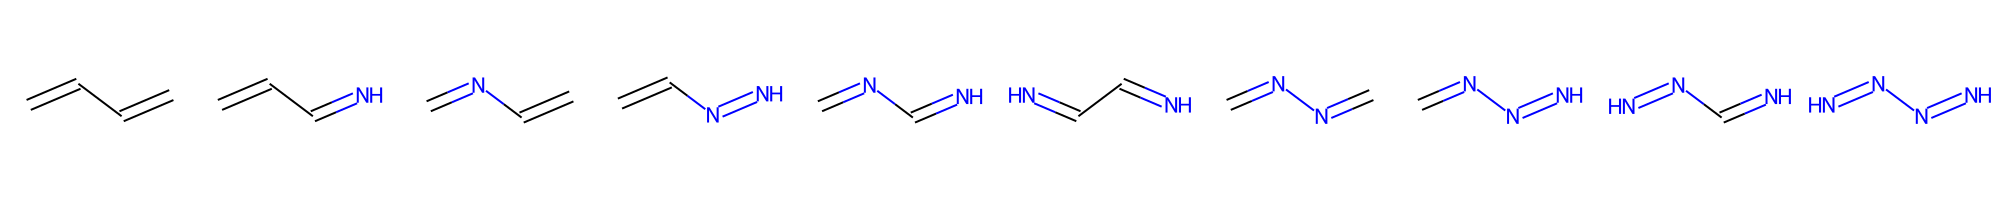

In [4]:
## Generate the product
def has_substructure(smi, sub_struct=None):
    if sub_struct is None:
        sub_struct = ['C=CC=C']
    mol = Chem.MolFromSmiles(smi) 
    if mol is None:
        match = False
    else:
        mol = Chem.RemoveHs( mol )
        Chem.Kekulize(mol)
        if any([mol.HasSubstructMatch( Chem.MolFromSmiles(s) ) for s in sub_struct]):
            match = True
        else:
            match = False
    return match

def replace_substructure(base_smi, replace_smi, add_smi):
    mol = Chem.ReplaceSubstructs(Chem.MolFromSmiles(base_smi), 
                                 Chem.MolFromSmiles(replace_smi), 
                                 Chem.MolFromSmiles(add_smi),
                                 replaceAll=False)
    smi = [ Chem.MolToSmiles(m, canonical=True, isomericSmiles=True) for m in mol ]
    smi = list(set(smi))
    if base_smi in smi:
        smi.remove(base_smi)
    return smi

def make_poduct(smi, patterns):    
    mol = Chem.MolFromSmiles(smi) 
    mol = Chem.RemoveHs( mol )
    Chem.Kekulize(mol)
    mol = Chem.RWMol(mol)
    
    m = [ i for i,p in enumerate(patterns) if has_substructure(smi, sub_struct=[p]) ]
    m = np.amax(m)
    matches = mol.GetSubstructMatches( Chem.MolFromSmiles(patterns[m]) )
    #print(matches)
    m = list(matches[0])
    img1 = Draw.MolToImage(mol, highlightAtoms=m, kekulize=True)
    
    new_bond_single = Chem.BondType.SINGLE
    new_bond_double = Chem.BondType.DOUBLE

    bond = mol.GetBondBetweenAtoms(m[0],m[1])
    bond.SetBondType( new_bond_single )
    bond = mol.GetBondBetweenAtoms(m[1],m[2])
    bond.SetBondType( new_bond_double )
    bond = mol.GetBondBetweenAtoms(m[2],m[3])
    bond.SetBondType( new_bond_single )

    new_atom_index1 = mol.AddAtom(Chem.Atom("C"))
    mol.AddBond(m[0], new_atom_index1, new_bond_single)
    new_atom_index2 = mol.AddAtom(Chem.Atom("O"))
    mol.AddBond(m[3], new_atom_index2, new_bond_single)
    mol.AddBond(new_atom_index1, new_atom_index2, new_bond_single)
    new_atom_index3 = mol.AddAtom(Chem.Atom("O"))
    mol.AddBond(new_atom_index1, new_atom_index3, new_bond_double)

    Chem.AllChem.Compute2DCoords(mol)
    
    new_smiles = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=True)
    
    img2 = Draw.MolToImage(mol, highlightAtoms=m, kekulize=True)
    #display( smi, new_smiles, img1, img2 )
    
    return new_smiles


patterns = ['C=CC=C','N=CC=C','C=NC=C','N=NC=C','N=CN=C','N=CC=N','C=NN=C','N=NN=C','N=NC=N','N=NN=N']
img1 = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in patterns], molsPerRow=10,  )
img1

In [13]:
## For each type, get the best 10
names_new = ['Aliphatic N=0']+['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']

selected_dienes = []
for d,m in zip(data_plot_new,names_new):
    d =d.sort_values(by='LUMO_predicted',ascending=True).head(10) 
    d = d[['SMILES','LUMO_predicted']]
    d['Type'] = m
    products = [ make_poduct(s, patterns) for s in d['SMILES'] ]
    d['Product'] = products
    selected_dienes.append(d)
selected_dienes = pd.concat(selected_dienes,axis=0).reset_index()
selected_dienes.to_csv('new_selected_dienes.csv')

for i,s in zip(selected_dienes.index, selected_dienes['SMILES']):
    smiles_to_xyz_pybel(s, if_write_xyz=f'xyz_selected_dienes/selected_dienes_{i}.xyz', if_overwrite=True) 

for i,s in zip(selected_dienes.index, selected_dienes['Product']):
    smiles_to_xyz_pybel(s, if_write_xyz=f'xyz_selected_dienes/product_selected_dienes_{i}.xyz', if_overwrite=True) 

In [14]:
d = data_plot_old[2][['SMILES','LUMO','LUMO_predicted']].sort_values(by='LUMO_predicted',ascending=True).head(10).reset_index()
products = [ make_poduct(s, patterns) for s in d['SMILES'] ]
d['Product'] = products
d.to_csv('old_selected_dienes.csv')

for i,s in zip(d.index, d['SMILES']):
    smiles_to_xyz_pybel(s, if_write_xyz=f'xyz_selected_dienes/old_selected_dienes_{i}.xyz', if_overwrite=True) 
for i,s in zip(d.index, d['Product']):
    smiles_to_xyz_pybel(s, if_write_xyz=f'xyz_selected_dienes/product_old_selected_dienes_{i}.xyz', if_overwrite=True) 

In [5]:
## Read the DFT LUMO energies from file
df_selected_old = pd.read_csv('old_selected_dienes.csv', index_col=0)
df_selected_new = pd.read_csv('new_selected_dienes.csv', index_col=0)
dft_old1 = pd.read_csv('df_diene_old_lumo.csv', index_col=0)
dft_new1 = pd.read_csv('df_diene_new_lumo.csv', index_col=0)
dft_old2 = pd.read_csv('df_product_old_lumo.csv', index_col=0)
dft_new2 = pd.read_csv('df_product_new_lumo.csv', index_col=0)

dft_old1 = dft_old1.rename( columns={c:c+'_reactant' for c in dft_old1.columns} )
dft_new1 = dft_new1.rename( columns={c:c+'_reactant' for c in dft_new1.columns} )
dft_old2 = dft_old2.rename( columns={c:c+'_product' for c in dft_old2.columns} )
dft_new2 = dft_new2.rename( columns={c:c+'_product' for c in dft_new2.columns} )

df_selected_old = pd.concat( [df_selected_old, dft_old1, dft_old2], axis=1)
df_selected_new = pd.concat( [df_selected_new, dft_new1, dft_new2], axis=1)

df_selected_old = df_selected_old.sort_values(by='LUMO_DFT(eV)_reactant',ascending=True)
df_selected_new = df_selected_new.sort_values(by='LUMO_DFT(eV)_reactant',ascending=True)

display(df_selected_old,df_selected_new)

,index,SMILES,LUMO,LUMO_predicted,Product,E_DFT(eV)_reactant,LUMO_DFT(eV)_reactant,HOMO_DFT(eV)_reactant,E_DFT(eV)_product,LUMO_DFT(eV)_product,HOMO_DFT(eV)_product
3,21284,O=c1oncc(n1)C#N,-4.20,-4.00,N#Cc1cn2oc(=O)n1OC2=O,-12713.72,-4.25,-8.89,-17838.51,-3.74,-9.26
1,21290,O=c1oncnc1C#N,-4.17,-4.06,N#Cc12ncn(oc1=O)C(=O)O2,-12713.68,-4.24,-8.69,-17840.00,-3.43,-9.02
0,21191,O=C(C#N)n1nnnn1,-4.15,-4.07,N#CC(=O)n1n2nnn1C(=O)O2,-13045.07,-4.15,-9.99,-18172.24,-3.64,-8.63
4,21293,O=c1onnc(c1)C#N,-4.02,-3.98,N#Cc1nn2oc(=O)c1OC2=O,-12713.32,-4.09,-8.91,-17839.50,-4.04,-8.99
8,21369,O=Cc1nc(=O)onc1,-4.01,-3.82,O=Cc1cn2OC(=O)n1c(=O)o2,-13287.39,-4.06,-8.27,-18412.17,-3.46,-8.50
7,22218,O=N(=O)c1cnnnn1,-4.01,-3.87,O=C1On2nnn1cc2[N+](=O)[O-],-13615.86,-4.04,-8.54,-18744.38,-4.08,-8.89
6,21277,O=c1onc(cn1)C#N,-3.99,-3.90,N#Cc1cn2OC(=O)n1oc2=O,-12713.73,-4.03,-8.87,-17838.51,-3.74,-9.26
5,21279,O=c1onc(nc1)C#N,-3.88,-3.93,N#Cc1nc2OC(=O)n1oc2=O,-12713.63,-3.94,-8.67,-17840.22,-3.96,-8.93
2,21184,O=C(C#N)c1nonn1,-3.91,-4.03,N#CC(=O)c1nn2on1OC2=O,-13148.82,-3.93,-9.76,-18272.39,-4.71,-9.56
9,21173,O=C(C#N)c1cnno1,-3.86,-3.79,N#CC(=O)c12cnn(o1)C(=O)O2,-12713.47,-3.89,-9.31,-17838.65,-3.91,-9.19


,index,SMILES,LUMO_predicted,Type,Product,E_DFT(eV)_reactant,LUMO_DFT(eV)_reactant,HOMO_DFT(eV)_reactant,E_DFT(eV)_product,LUMO_DFT(eV)_product,HOMO_DFT(eV)_product
75,201442,N#CC1=NC(C#N)([N+](=O)[O-])C(=O)C(C#N)=N1,-3.40,Ring 6 with =O,N#CC1=NC2(C#N)OC(=O)N1C(C#N)([N+](=O)[O-])C2=O,-22312.47,-5.66,-9.22,-27439.08,-4.37,-9.43
34,199,N#CC1=NN=C([N+](=O)[O-])C1=O,-3.38,Ring 5 with =O,N#CC12N=NC([N+](=O)[O-])(OC1=O)C2=O,-16227.99,-5.61,-9.28,-21355.13,-3.89,-9.16
39,195,N#CC1=NN=C(C#N)C1=O,-3.31,Ring 5 with =O,N#CC12N=NC(C#N)(C(=O)O1)C2=O,-13175.39,-5.52,-9.16,-18302.21,-3.88,-9.02
77,66307,N#CC1=NC(=O)C(C#N)([N+](=O)[O-])N=N1,-3.40,Ring 6 with =O,N#CC1=NN2C(=O)ON1C(=O)C2(C#N)[N+](=O)[O-],-20240.33,-5.48,-8.88,-25365.50,-4.47,-9.21
37,608,N#CC1=NC(=O)C(C#N)=N1,-3.33,Ring 5 with =O,N#CC1=NC2(C#N)OC(=O)N1C2=O,-13176.48,-5.39,-9.54,-18302.74,-3.98,-9.77
...,...,...,...,...,...,...,...,...,...,...,...
54,1272166,CSC1=NC(C#N)=NCC1([N+](=O)[O-])[N+](=O)[O-],-3.38,Ring 6 with C-C,CSC12N=C(C#N)N(CC1([N+](=O)[O-])[N+](=O)[O-])C...,-32746.90,-3.41,-7.93,-37873.41,-3.66,-7.77
23,157,N#Cc1nnc(C=O)o1,-3.57,Ring 5 with O,N#Cc12nnc(C=O)(OC1=O)o2,-12714.25,-3.40,-8.85,-17839.93,-3.28,-8.70
14,4927,N=NC1([N+](=O)[O-])N=NN=N1,-3.46,Ring 5,N=NC1([N+](=O)[O-])N2N=NN1C(=O)O2,-15555.71,-3.31,-7.63,-20680.58,-3.67,-8.74
12,4865,O=CC1([N+](=O)[O-])N=NN=N1,-3.48,Ring 5,O=CC1([N+](=O)[O-])N2N=NN1C(=O)O2,-15663.50,-3.11,-8.39,-20785.83,-3.63,-9.39


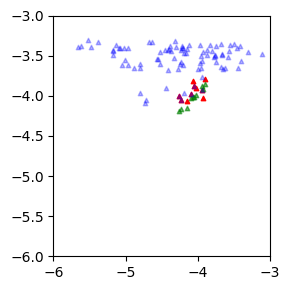

In [6]:
fig, axs = plt.subplots(1,1,figsize=(3,3),tight_layout=True,dpi=100)
#sns.scatterplot(data=df_selected_new, x="LUMO_predicted", y="LUMO_DFT")
axs.scatter( df_selected_old["LUMO_DFT(eV)_reactant"], df_selected_old["LUMO_predicted"], s=10, marker='^', c='r')
axs.scatter( df_selected_old["LUMO_DFT(eV)_reactant"], df_selected_old["LUMO"], s=10, marker='^', c='g', alpha=0.6)
axs.scatter( df_selected_new["LUMO_DFT(eV)_reactant"], df_selected_new["LUMO_predicted"], s=10, marker='^', c='b', alpha=0.3)

axs.set_xlim( (-6,-3) )
axs.set_ylim( (-6,-3) )
#display(df_selected_old,df_selected_new)
plt.show()

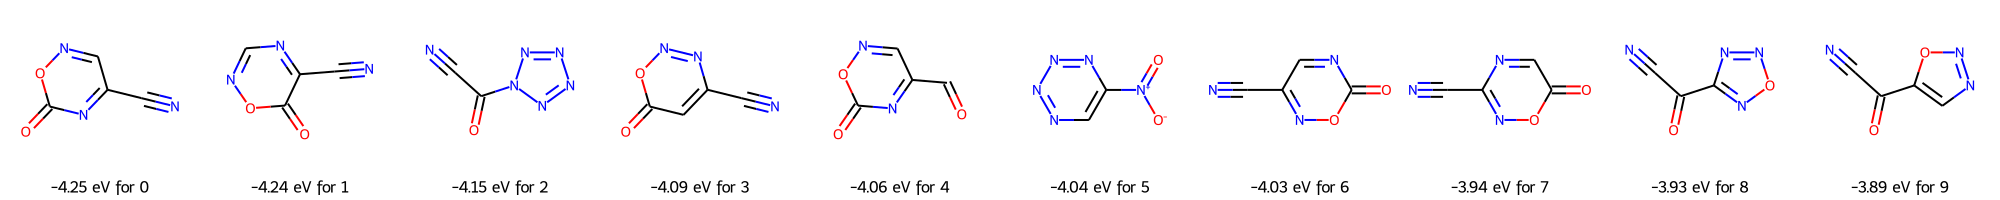

In [7]:
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_selected_old['SMILES']], 
                           molsPerRow=10, subImgSize=(200, 200), returnPNG=False, 
                           legends=[str(round(e,2))+' eV for '+str(i) for i,e in enumerate(df_selected_old['LUMO_DFT(eV)_reactant']) ] )  
#img.save('df_selected_old.png')
display(img)

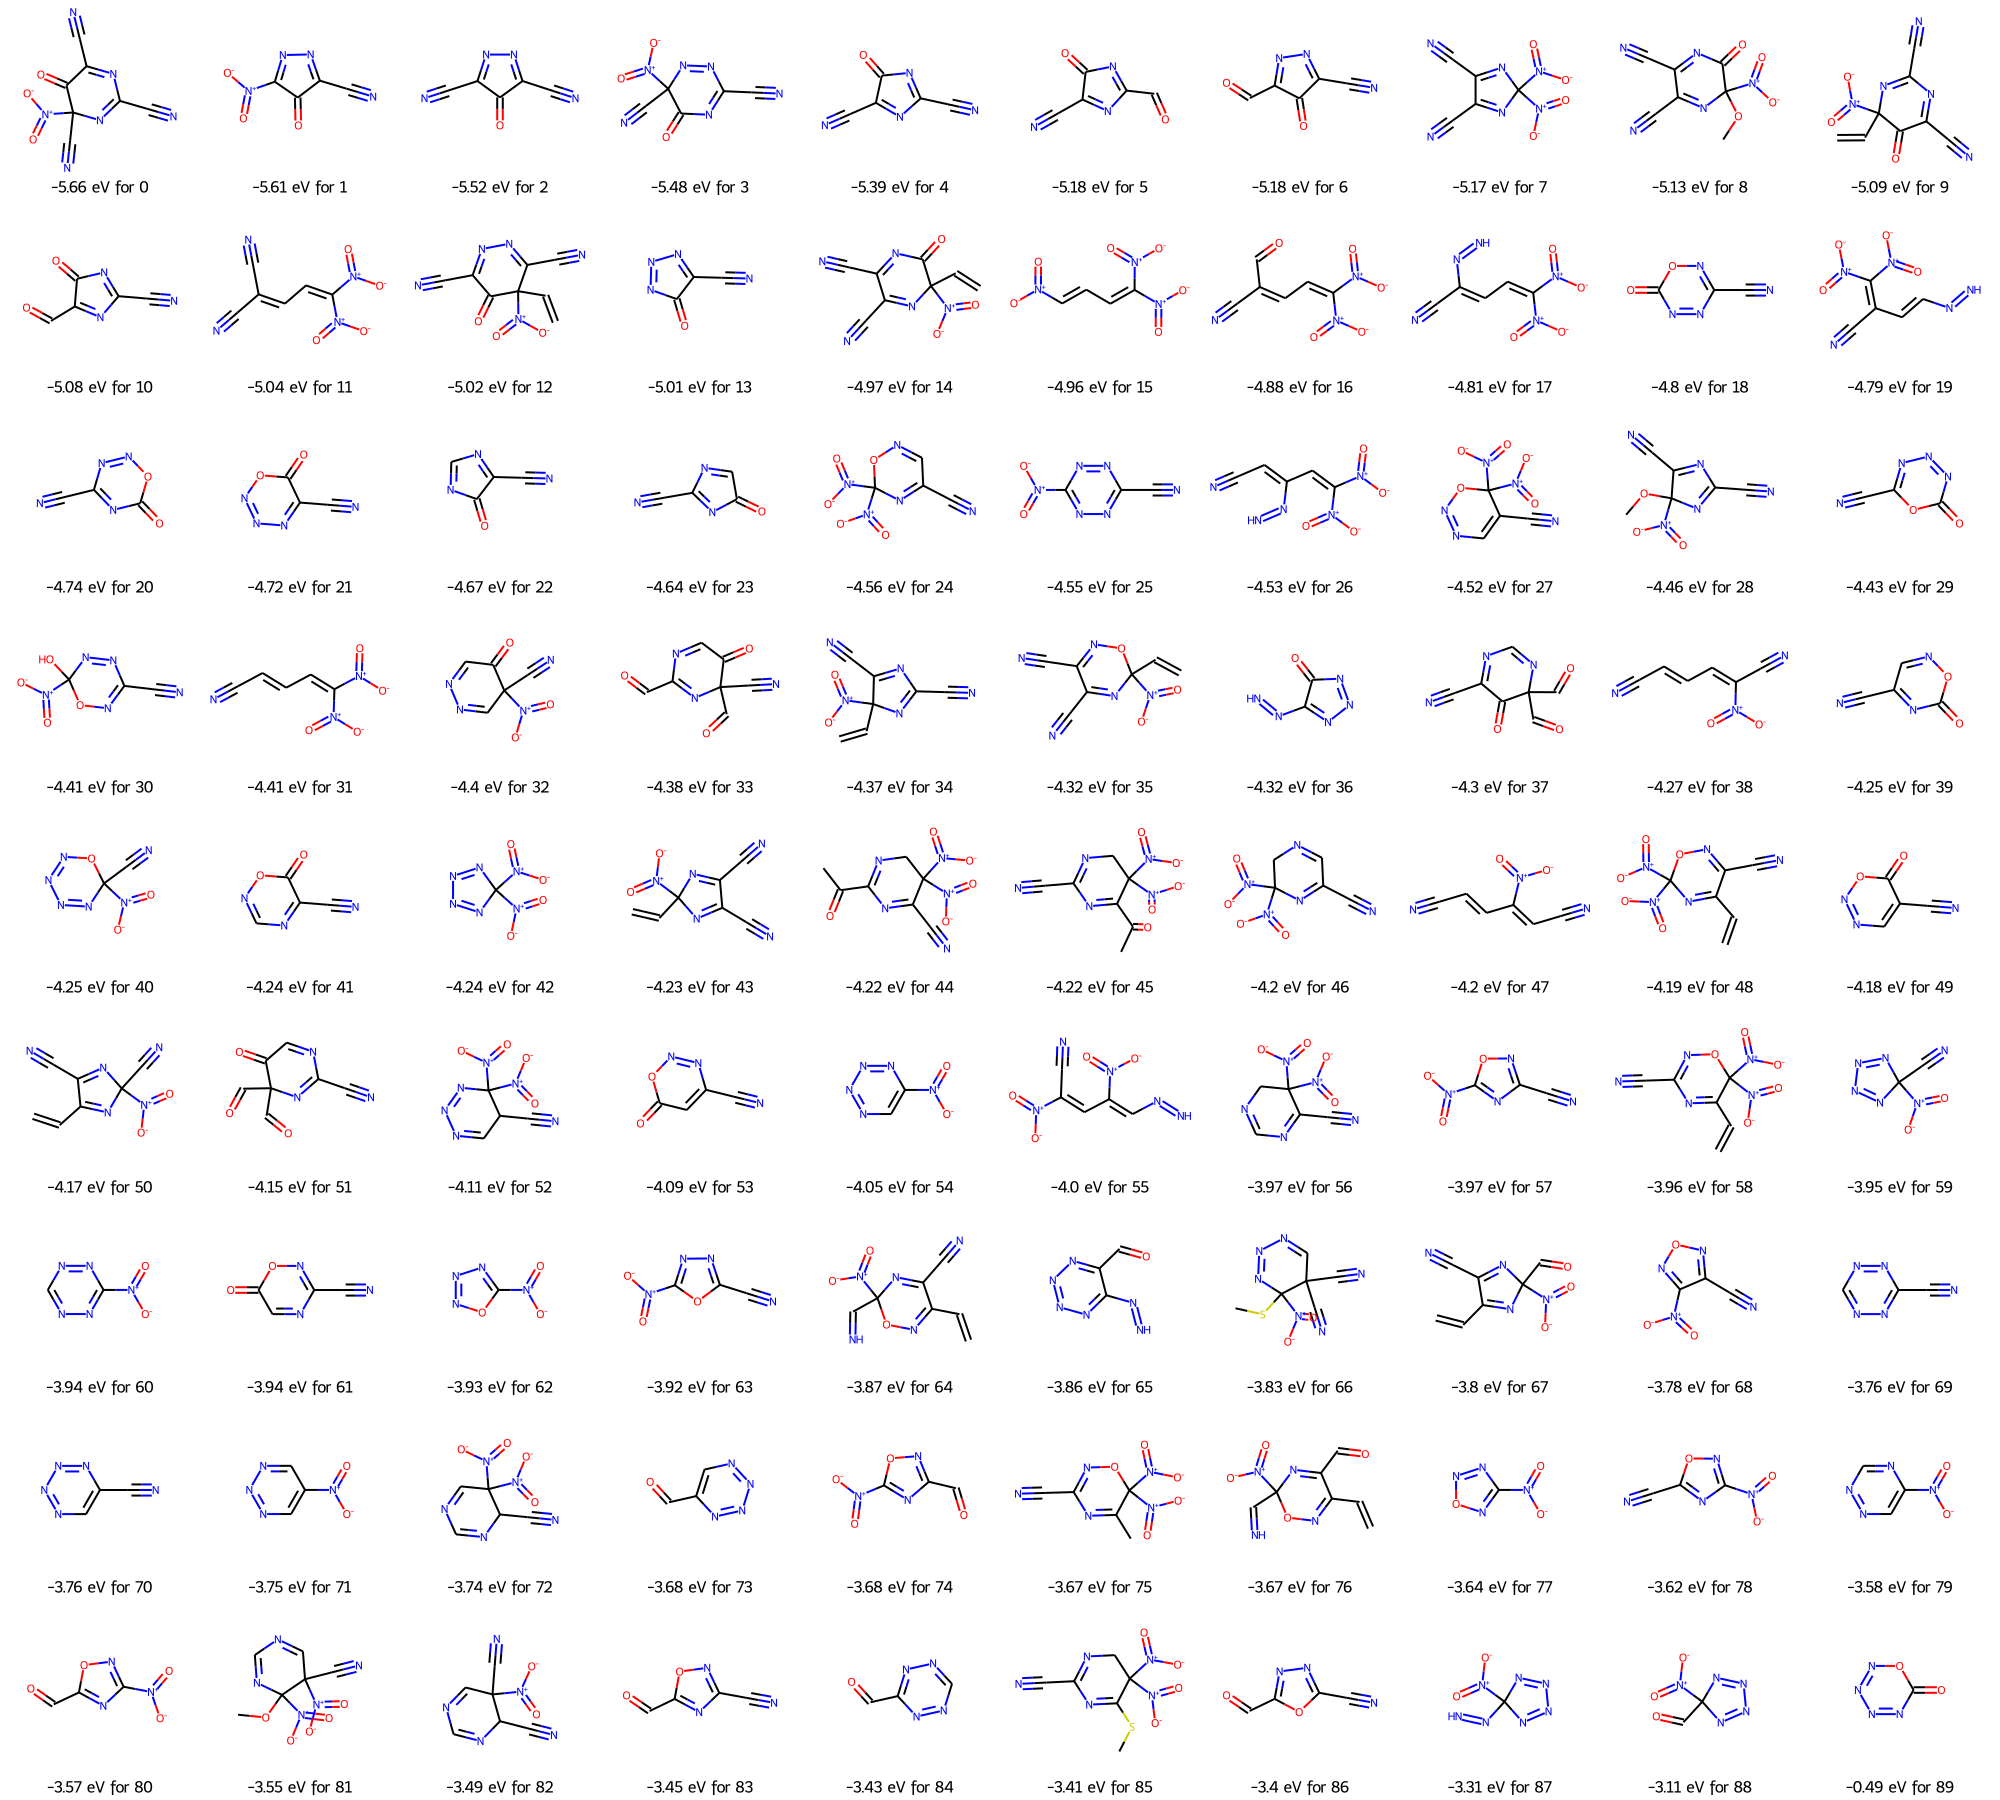

In [8]:
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_selected_new['SMILES']], 
                           molsPerRow=10, subImgSize=(200, 200), returnPNG=False, maxMols =100,
                           legends=[str(round(e,2))+' eV for '+str(i) for i,e in enumerate(df_selected_new['LUMO_DFT(eV)_reactant']) ] )  
#img.save('df_selected_old.png')
display(img)

['O=[N+]([O-])c1cnncn1', 'O=C1On2cnn1cc2[N+](=O)[O-]']
[8, 7, 6, 5]


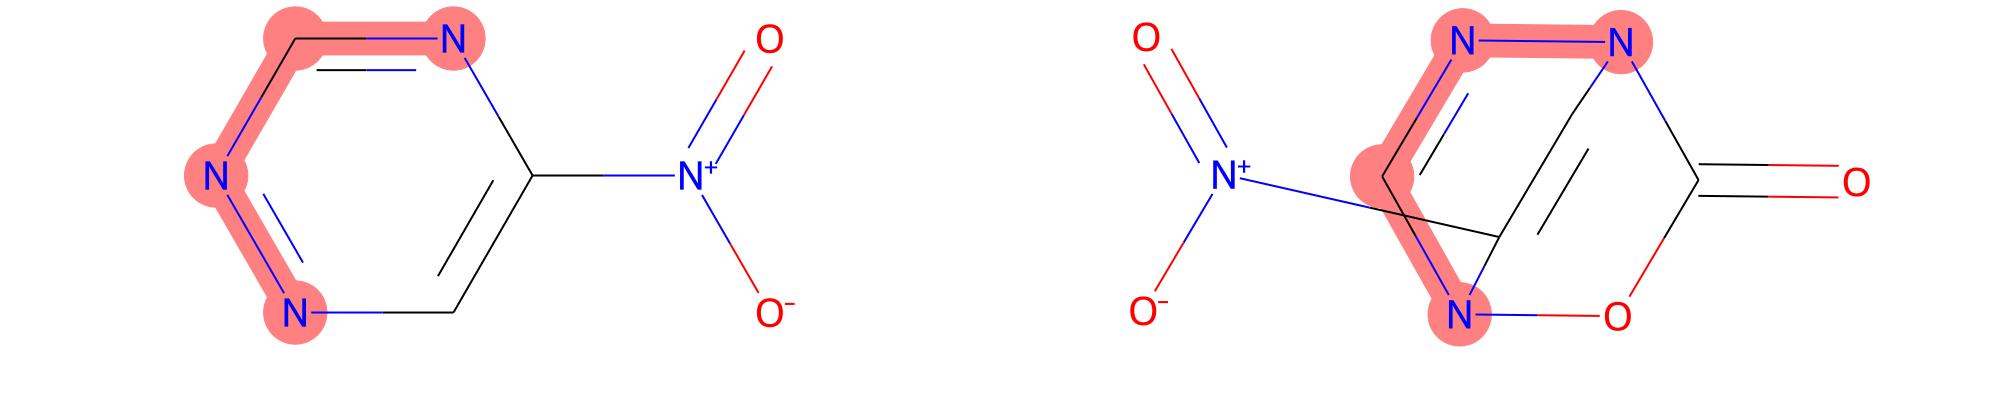

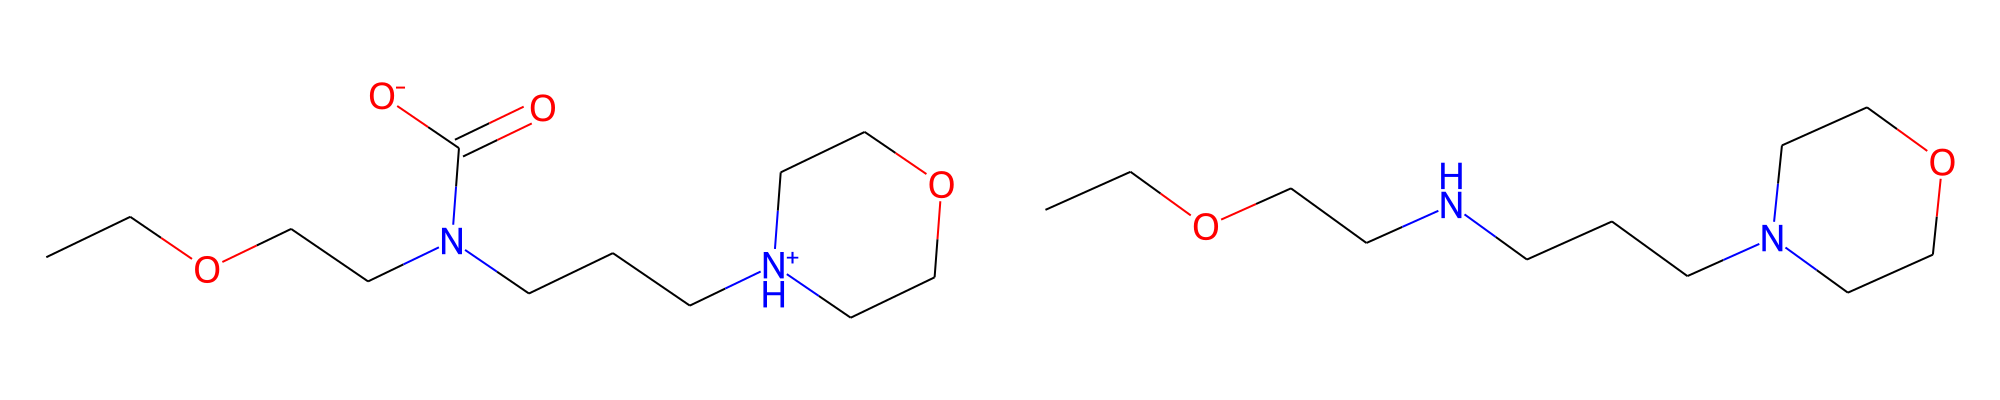

In [9]:
ss = list( df_selected_new.iloc[79][ ['SMILES','Product'] ] )
print(ss)

mol = Chem.RWMol( Chem.MolFromSmiles(ss[0]) )
Chem.Kekulize(mol)
matches1 = list(mol.GetSubstructMatches( Chem.MolFromSmiles('N=CN=N') )[0])
print(matches1)
'''
mol = Chem.RWMol( Chem.MolFromSmiles(ss[1]) )
Chem.Kekulize(mol)
matches2 = list(mol.GetSubstructMatches( Chem.MolFromSmiles('CN=NC') )[0])
print(matches2)
'''
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in ss],                            
                     molsPerRow=2, subImgSize=(1000, 400), returnPNG=False, #explicitOnly=True,
                     highlightAtomLists=[matches1, [3,4,5,6]] )
display( img )
img.save('snapshot_example_diene.png')

#img = Draw.MolToImage(Chem.MolFromSmiles(ss[1]), kekulize=True, wedgeBonds=True, explicitOnly=True)
#display( img )

eempas = ['CCOCCN(CCC[NH+]1CCOCC1)C(=O)[O-]','CCOCCNCCCN1CCOCC1']
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in eempas],                            
                     molsPerRow=2, subImgSize=(1000, 400), returnPNG=False)
display( img )
img.save('snapshot_EEMPA.png')


In [10]:
E_eempa= -18854.64909
E_eempa_COOH= -23982.88526
E_eempa_COO_H_zwt= -23982.2908

E_reaction_old = (df_selected_old['E_DFT(eV)_product'] + E_eempa)-(df_selected_old['E_DFT(eV)_reactant'] + E_eempa_COO_H_zwt)
df_selected_old['Reaction'] = E_reaction_old
E_reaction_new = (df_selected_new['E_DFT(eV)_product'] + E_eempa)-(df_selected_new['E_DFT(eV)_reactant'] + E_eempa_COO_H_zwt)
df_selected_new['Reaction'] = E_reaction_new

display(df_selected_old, df_selected_new)

,index,SMILES,LUMO,LUMO_predicted,Product,E_DFT(eV)_reactant,LUMO_DFT(eV)_reactant,HOMO_DFT(eV)_reactant,E_DFT(eV)_product,LUMO_DFT(eV)_product,HOMO_DFT(eV)_product,Reaction
3,21284,O=c1oncc(n1)C#N,-4.20,-4.00,N#Cc1cn2oc(=O)n1OC2=O,-12713.72,-4.25,-8.89,-17838.51,-3.74,-9.26,2.85
1,21290,O=c1oncnc1C#N,-4.17,-4.06,N#Cc12ncn(oc1=O)C(=O)O2,-12713.68,-4.24,-8.69,-17840.00,-3.43,-9.02,1.32
0,21191,O=C(C#N)n1nnnn1,-4.15,-4.07,N#CC(=O)n1n2nnn1C(=O)O2,-13045.07,-4.15,-9.99,-18172.24,-3.64,-8.63,0.46
4,21293,O=c1onnc(c1)C#N,-4.02,-3.98,N#Cc1nn2oc(=O)c1OC2=O,-12713.32,-4.09,-8.91,-17839.50,-4.04,-8.99,1.46
8,21369,O=Cc1nc(=O)onc1,-4.01,-3.82,O=Cc1cn2OC(=O)n1c(=O)o2,-13287.39,-4.06,-8.27,-18412.17,-3.46,-8.50,2.86
7,22218,O=N(=O)c1cnnnn1,-4.01,-3.87,O=C1On2nnn1cc2[N+](=O)[O-],-13615.86,-4.04,-8.54,-18744.38,-4.08,-8.89,-0.87
6,21277,O=c1onc(cn1)C#N,-3.99,-3.90,N#Cc1cn2OC(=O)n1oc2=O,-12713.73,-4.03,-8.87,-17838.51,-3.74,-9.26,2.86
5,21279,O=c1onc(nc1)C#N,-3.88,-3.93,N#Cc1nc2OC(=O)n1oc2=O,-12713.63,-3.94,-8.67,-17840.22,-3.96,-8.93,1.05
2,21184,O=C(C#N)c1nonn1,-3.91,-4.03,N#CC(=O)c1nn2on1OC2=O,-13148.82,-3.93,-9.76,-18272.39,-4.71,-9.56,4.07
9,21173,O=C(C#N)c1cnno1,-3.86,-3.79,N#CC(=O)c12cnn(o1)C(=O)O2,-12713.47,-3.89,-9.31,-17838.65,-3.91,-9.19,2.47


,index,SMILES,LUMO_predicted,Type,Product,E_DFT(eV)_reactant,LUMO_DFT(eV)_reactant,HOMO_DFT(eV)_reactant,E_DFT(eV)_product,LUMO_DFT(eV)_product,HOMO_DFT(eV)_product,Reaction
75,201442,N#CC1=NC(C#N)([N+](=O)[O-])C(=O)C(C#N)=N1,-3.40,Ring 6 with =O,N#CC1=NC2(C#N)OC(=O)N1C(C#N)([N+](=O)[O-])C2=O,-22312.47,-5.66,-9.22,-27439.08,-4.37,-9.43,1.03
34,199,N#CC1=NN=C([N+](=O)[O-])C1=O,-3.38,Ring 5 with =O,N#CC12N=NC([N+](=O)[O-])(OC1=O)C2=O,-16227.99,-5.61,-9.28,-21355.13,-3.89,-9.16,0.50
39,195,N#CC1=NN=C(C#N)C1=O,-3.31,Ring 5 with =O,N#CC12N=NC(C#N)(C(=O)O1)C2=O,-13175.39,-5.52,-9.16,-18302.21,-3.88,-9.02,0.82
77,66307,N#CC1=NC(=O)C(C#N)([N+](=O)[O-])N=N1,-3.40,Ring 6 with =O,N#CC1=NN2C(=O)ON1C(=O)C2(C#N)[N+](=O)[O-],-20240.33,-5.48,-8.88,-25365.50,-4.47,-9.21,2.47
37,608,N#CC1=NC(=O)C(C#N)=N1,-3.33,Ring 5 with =O,N#CC1=NC2(C#N)OC(=O)N1C2=O,-13176.48,-5.39,-9.54,-18302.74,-3.98,-9.77,1.38
...,...,...,...,...,...,...,...,...,...,...,...,...
54,1272166,CSC1=NC(C#N)=NCC1([N+](=O)[O-])[N+](=O)[O-],-3.38,Ring 6 with C-C,CSC12N=C(C#N)N(CC1([N+](=O)[O-])[N+](=O)[O-])C...,-32746.90,-3.41,-7.93,-37873.41,-3.66,-7.77,1.13
23,157,N#Cc1nnc(C=O)o1,-3.57,Ring 5 with O,N#Cc12nnc(C=O)(OC1=O)o2,-12714.25,-3.40,-8.85,-17839.93,-3.28,-8.70,1.97
14,4927,N=NC1([N+](=O)[O-])N=NN=N1,-3.46,Ring 5,N=NC1([N+](=O)[O-])N2N=NN1C(=O)O2,-15555.71,-3.31,-7.63,-20680.58,-3.67,-8.74,2.77
12,4865,O=CC1([N+](=O)[O-])N=NN=N1,-3.48,Ring 5,O=CC1([N+](=O)[O-])N2N=NN1C(=O)O2,-15663.50,-3.11,-8.39,-20785.83,-3.63,-9.39,5.30


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

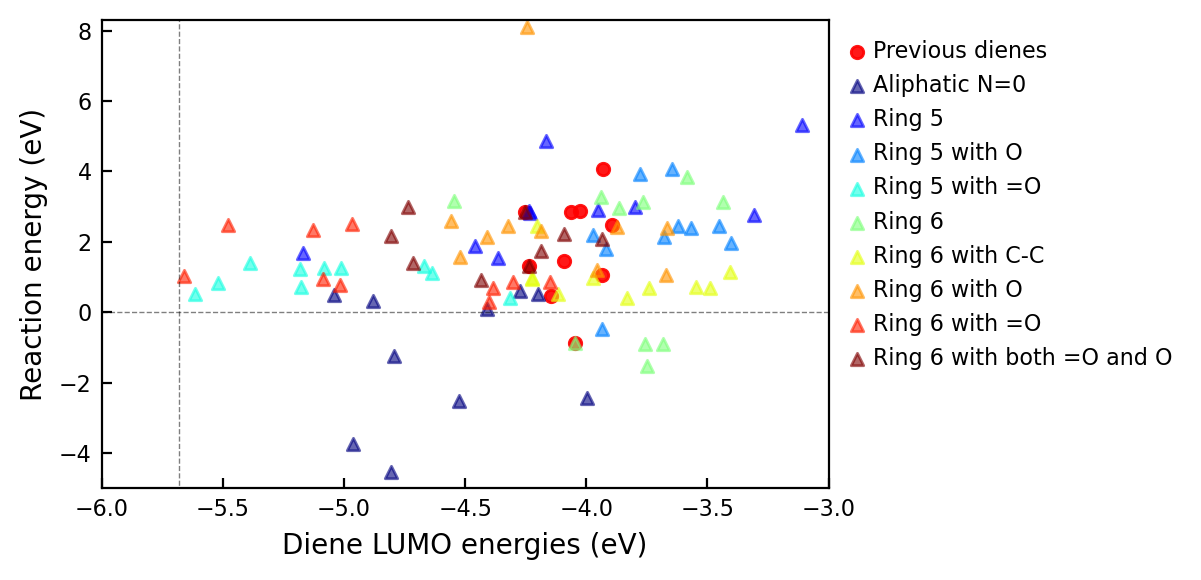

In [40]:
fig, axs = plt.subplots(1,1,figsize=(7,3),tight_layout=True,dpi=200)

#names = list(df_selected_new['Type'].value_counts().index)
names = ['Aliphatic N=0']+['Ring 5','Ring 5 with O','Ring 5 with =O','Ring 6','Ring 6 with C-C','Ring 6 with O','Ring 6 with =O','Ring 6 with both =O and O']
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, len(names)))
colors = {m:c for m,c in zip(names,colors) }
#colors = [ colors[t] for t in df_selected_new['Type'] ]

axs.scatter( df_selected_old["LUMO_DFT(eV)_reactant"], df_selected_old["Reaction"], s=20, marker='o', c='r', alpha=0.9, label='Previous dienes')
for m in names:
    df = df_selected_new[ df_selected_new['Type']==m ]
    axs.scatter( df["LUMO_DFT(eV)_reactant"], df["Reaction"], s=20, marker='^', c=colors[m], alpha=0.6, label=m)

axs.set_xlabel('Diene LUMO energies (eV)', fontsize=10)
axs.set_ylabel('Reaction energy (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
#axs.set_xticks( [] ) axs.set_xticklabels([])
axs.legend( fontsize=8, frameon=False, ncol=1, loc=1, #labels=['Previous dienes','New dienes'], 
           handlelength=1, handletextpad=0.2, columnspacing=1, bbox_to_anchor=(1.5,1) )
axs.set_xlim( (-6,-3) )
axs.set_ylim( (-5,8.3) )

axs.plot( [-100,100],[0,0], '--', color='k', lw=0.5, alpha=0.5)
axs.plot( [-5.68, -5.68],[-100,100], '--', color='k', lw=0.5, alpha=0.5)
#plt.savefig("Selected_new_dienes.png", dpi=800)  
plt.show()


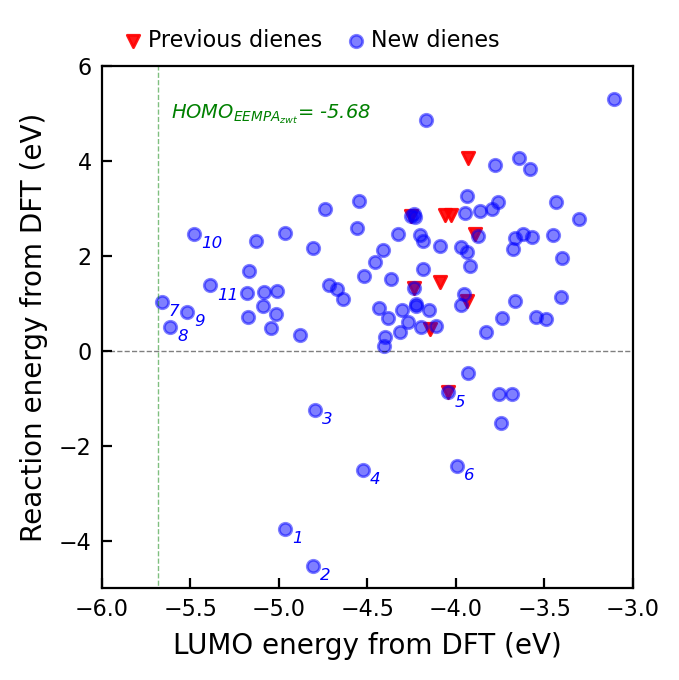

,index,SMILES,LUMO_predicted,Type,Product,E_DFT(eV)_reactant,LUMO_DFT(eV)_reactant,HOMO_DFT(eV)_reactant,E_DFT(eV)_product,LUMO_DFT(eV)_product,HOMO_DFT(eV)_product,Reaction
5,32891,O=[N+]([O-])C=CC=C([N+](=O)[O-])[N+](=O)[O-],-3.62,Aliphatic N=0,O=C1OC([N+](=O)[O-])([N+](=O)[O-])C=CC1[N+](=O...,-20917.90,-4.96,-6.16,-26049.29,-3.22,-9.24,-3.76
9,423776,N#CC(=CC=C([N+](=O)[O-])[N+](=O)[O-])N=N,-3.60,Aliphatic N=0,N#CC1=NNC(=O)OC1C=C([N+](=O)[O-])[N+](=O)[O-],-20840.55,-4.81,-6.02,-25972.72,-3.80,-8.54,-4.53
4,421677,N#CC(C=CN=N)=C([N+](=O)[O-])[N+](=O)[O-],-3.65,Aliphatic N=0,N#CC(=C([N+](=O)[O-])[N+](=O)[O-])C1C=NNC(=O)O1,-20843.47,-4.79,-7.85,-25972.35,-4.36,-8.30,-1.24
8,423775,N#CC=C(C=C([N+](=O)[O-])[N+](=O)[O-])N=N,-3.61,Aliphatic N=0,N#CC1OC(=O)NN=C1C=C([N+](=O)[O-])[N+](=O)[O-],-20842.64,-4.53,-5.95,-25972.79,-4.09,-8.47,-2.51
40,269,O=[N+]([O-])c1cnnnn1,-3.87,Ring 6,O=C1On2nnn1cc2[N+](=O)[O-],-13615.86,-4.05,-8.54,-18744.38,-4.08,-8.88,-0.87
2,423892,N#CC(=CC(=CN=N)[N+](=O)[O-])[N+](=O)[O-],-3.66,Aliphatic N=0,N#CC(=CC1([N+](=O)[O-])C=NNC(=O)O1)[N+](=O)[O-],-20842.75,-4.00,-6.59,-25972.82,-4.08,-8.42,-2.43
24,101,O=[N+]([O-])c1nnno1,-3.56,Ring 5 with O,O=C1Oc2([N+](=O)[O-])nnn1o2,-13120.86,-3.93,-9.88,-18248.96,-3.38,-8.96,-0.46
47,265,N#Cc1cnnnn1,-3.50,Ring 6,N#Cc1cn2nnn1OC2=O,-10562.99,-3.76,-8.33,-15691.55,-3.93,-8.80,-0.91
44,161,O=[N+]([O-])c1cnnnc1,-3.58,Ring 6,O=C1Oc2nnn1cc2[N+](=O)[O-],-13180.72,-3.75,-8.20,-18309.88,-3.15,-8.60,-1.52
43,261,O=Cc1cnnnn1,-3.64,Ring 6,O=Cc1cn2nnn1OC2=O,-11136.41,-3.68,-7.90,-16264.96,-3.80,-8.32,-0.91


,index,SMILES,LUMO_predicted,Type,Product,E_DFT(eV)_reactant,LUMO_DFT(eV)_reactant,HOMO_DFT(eV)_reactant,E_DFT(eV)_product,LUMO_DFT(eV)_product,HOMO_DFT(eV)_product,Reaction
75,201442,N#CC1=NC(C#N)([N+](=O)[O-])C(=O)C(C#N)=N1,-3.40,Ring 6 with =O,N#CC1=NC2(C#N)OC(=O)N1C(C#N)([N+](=O)[O-])C2=O,-22312.47,-5.66,-9.22,-27439.08,-4.37,-9.43,1.03
34,199,N#CC1=NN=C([N+](=O)[O-])C1=O,-3.38,Ring 5 with =O,N#CC12N=NC([N+](=O)[O-])(OC1=O)C2=O,-16227.99,-5.61,-9.28,-21355.13,-3.89,-9.16,0.50
39,195,N#CC1=NN=C(C#N)C1=O,-3.31,Ring 5 with =O,N#CC12N=NC(C#N)(C(=O)O1)C2=O,-13175.39,-5.52,-9.16,-18302.21,-3.88,-9.02,0.82
77,66307,N#CC1=NC(=O)C(C#N)([N+](=O)[O-])N=N1,-3.40,Ring 6 with =O,N#CC1=NN2C(=O)ON1C(=O)C2(C#N)[N+](=O)[O-],-20240.33,-5.48,-8.88,-25365.50,-4.47,-9.21,2.47
37,608,N#CC1=NC(=O)C(C#N)=N1,-3.33,Ring 5 with =O,N#CC1=NC2(C#N)OC(=O)N1C2=O,-13176.48,-5.39,-9.54,-18302.74,-3.98,-9.77,1.38
31,543,N#CC1=NC(C=O)=NC1=O,-3.49,Ring 5 with =O,N#CC12N=C(C=O)N(C(=O)O1)C2=O,-13749.96,-5.18,-8.79,-18876.37,-3.95,-9.02,1.23
32,157,N#CC1=NN=C(C=O)C1=O,-3.43,Ring 5 with =O,N#CC12N=NC(C=O)(OC1=O)C2=O,-13748.93,-5.18,-8.57,-18875.86,-3.47,-8.70,0.71
15,207603,N#CC1=NC([N+](=O)[O-])([N+](=O)[O-])N=C1C#N,-3.44,Ring 5,N#CC1=C(C#N)N2C(=O)ON1C2([N+](=O)[O-])[N+](=O)...,-22284.54,-5.17,-9.95,-27410.49,-4.32,-9.52,1.69
79,265801,COC1([N+](=O)[O-])N=C(C#N)C(C#N)=NC1=O,-3.37,Ring 6 with =O,COC1([N+](=O)[O-])C(=O)N2OC(=O)N1C(C#N)=C2C#N,-22919.20,-5.13,-8.58,-28044.52,-4.16,-9.05,2.32
74,192002,C=CC1([N+](=O)[O-])N=C(C#N)N=C(C#N)C1=O,-3.40,Ring 6 with =O,C=CC1([N+](=O)[O-])C(=O)C2(C#N)N=C(C#N)N1C(=O)O2,-21909.46,-5.09,-8.58,-27036.15,-3.87,-8.82,0.95


In [117]:
fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True,dpi=200)

df_reaction_good = df_selected_new[ df_selected_new['Reaction']<0 ]
df_lumo_good = df_selected_new[ df_selected_new['LUMO_DFT(eV)_reactant']<(-5.68+1) ]

axs.scatter( df_selected_old["LUMO_DFT(eV)_reactant"], df_selected_old["Reaction"], s=20, marker='v', c='r', alpha=0.9, label='Previous dienes')
axs.scatter( df_selected_new["LUMO_DFT(eV)_reactant"], df_selected_new["Reaction"], s=20, marker='o', c='b', alpha=0.5, label='New dienes')

axs.set_xlabel('LUMO energy from DFT (eV)', fontsize=10)
axs.set_ylabel('Reaction energy from DFT (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
#axs.set_xticks( [] ) axs.set_xticklabels([])
axs.legend( fontsize=8, frameon=False, ncol=2, loc=2, #labels=['Previous dienes','New dienes'], 
           handlelength=1, handletextpad=0.2, columnspacing=1, bbox_to_anchor=(0,1.11) )
axs.set_xlim( (-6,-3) )
axs.set_ylim( (-5,6) )

axs.plot( [-100,100],[0,0], '--', color='k', lw=0.5, alpha=0.5)
axs.plot( [-5.68, -5.68],[-100,100], '--', color='g', lw=0.5, alpha=0.5)
    
axs.text(0.13,0.9, r'HOMO$_{EEMPA_{zwt}}$= -5.68',  style='italic', fontsize=7, transform = axs.transAxes, color='g') #backgroundcolor='white',

highlight_list = []
df =df_reaction_good.head(6)
for i,(s,l,e) in enumerate(zip(df["SMILES"], df["LUMO_DFT(eV)_reactant"], df["Reaction"])):
    axs.text(l+0.04,e-0.3,str(i+1),  style='italic', fontsize=6,  backgroundcolor='None',color='b')
    highlight_list.append( [s,str(i+1),l,e] )
df =df_lumo_good.head(5)
for i,(s,l,e) in enumerate(zip(df["SMILES"], df["LUMO_DFT(eV)_reactant"], df["Reaction"])):
    axs.text(l+0.04,e-0.3,str(i+7),  style='italic', fontsize=6,  backgroundcolor='None',color='b')
    highlight_list.append( [s,str(i+7),l,e] )
plt.savefig("Selected_new_dienes.png", dpi=800)  
plt.show()

display(df_reaction_good, df_lumo_good)

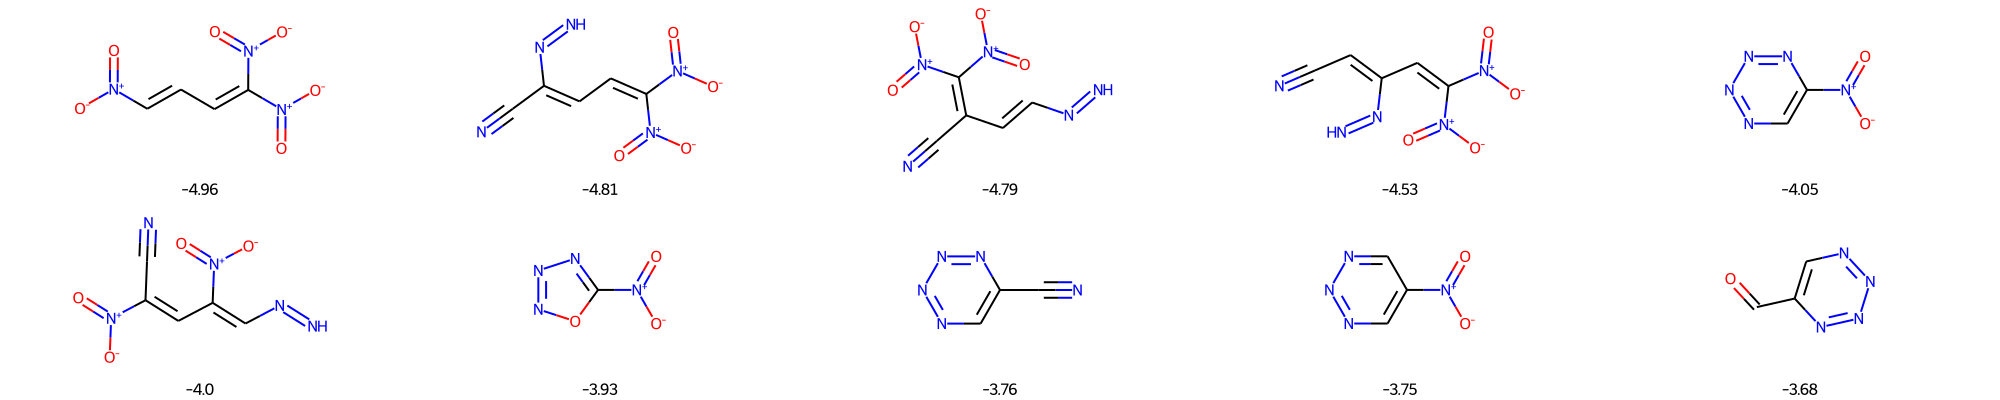

In [115]:
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_reaction_good['SMILES']], 
                           molsPerRow=5, subImgSize=(400, 200), returnPNG=False, maxMols =100,
                           legends=[str(round(e,2)) for i,e in enumerate(df_reaction_good['LUMO_DFT(eV)_reactant']) ] )  
img.save('df_reaction_good.png')
display(img)

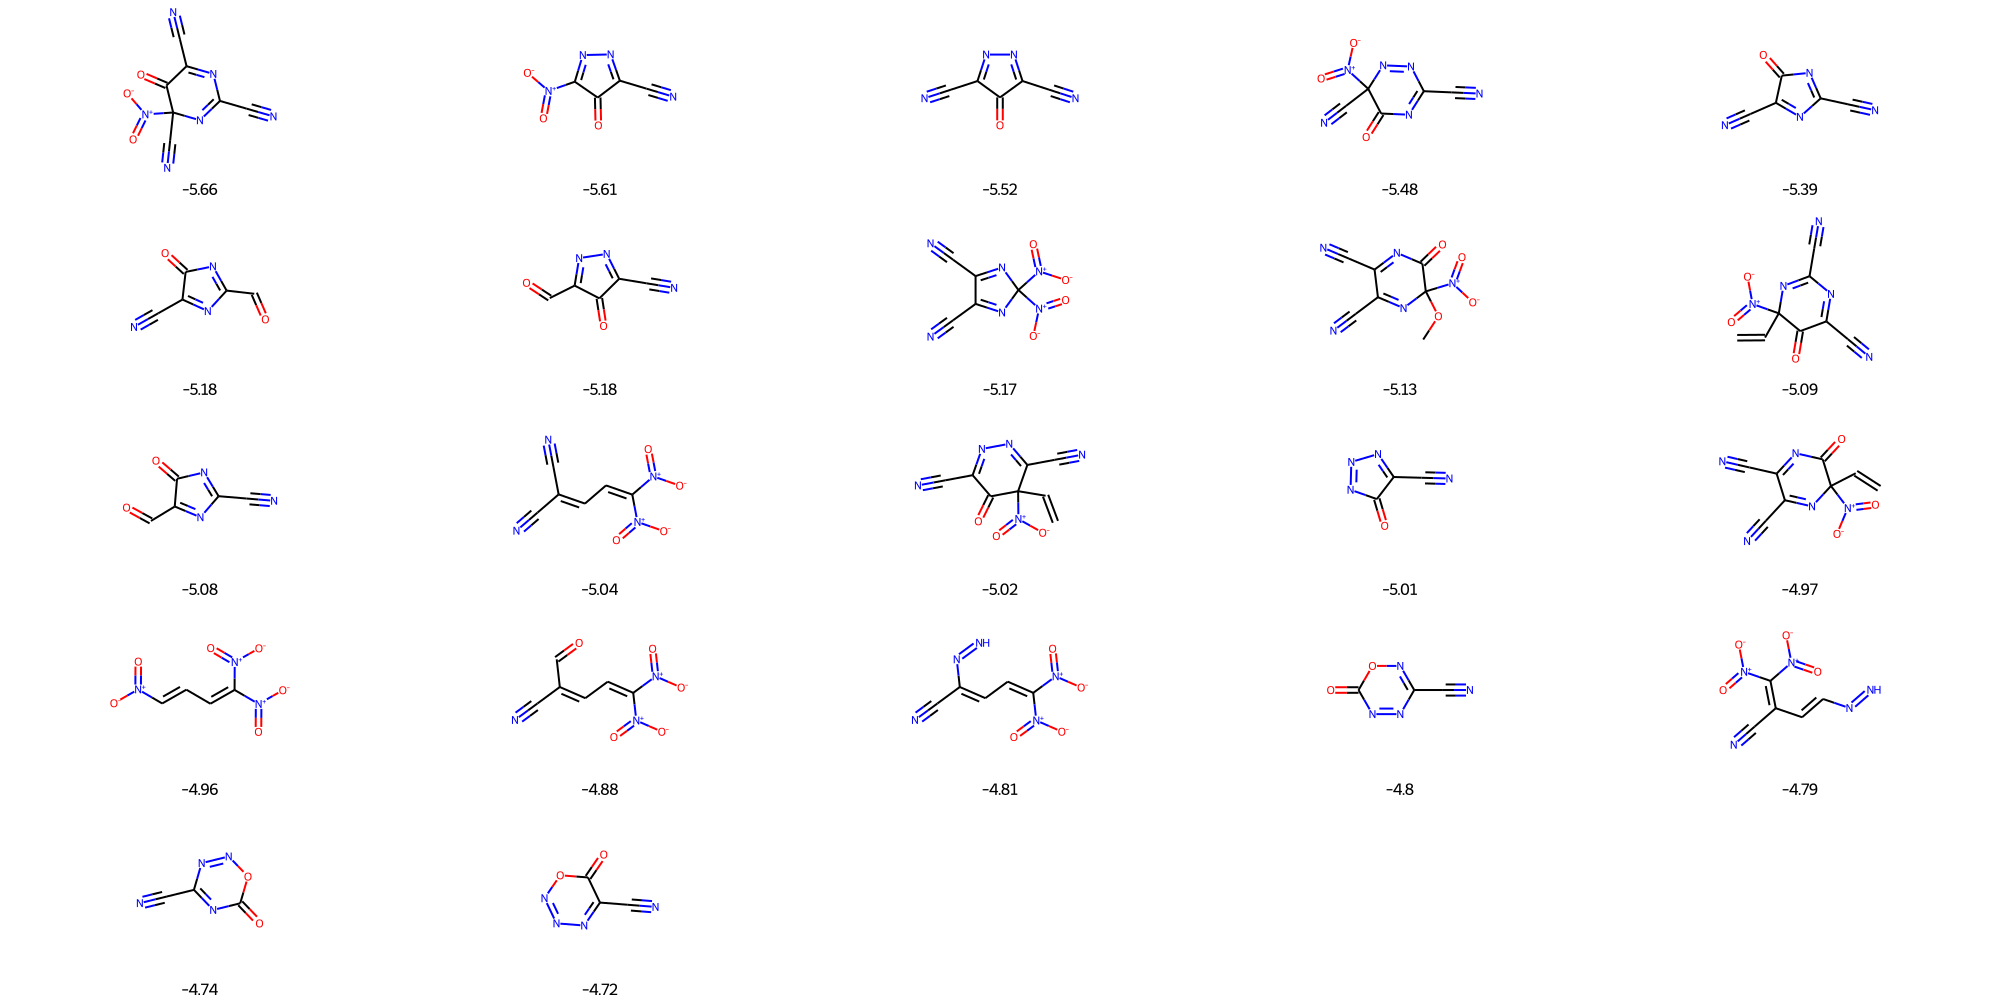

In [116]:
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in df_lumo_good['SMILES']], 
                           molsPerRow=5, subImgSize=(400, 200), returnPNG=False, maxMols=100,
                           legends=[str(round(e,2)) for i,e in enumerate(df_lumo_good['LUMO_DFT(eV)_reactant']) ] )  
img.save('df_lumo_good.png')
display(img)

['O=[N+]([O-])C=CC=C([N+](=O)[O-])[N+](=O)[O-]', '1', -4.964303595580001, -3.755543917606701]
['N#CC(=CC=C([N+](=O)[O-])[N+](=O)[O-])N=N', '2', -4.80633325516, -4.5309607883609715]
['N#CC(C=CN=N)=C([N+](=O)[O-])[N+](=O)[O-]', '3', -4.79472759306, -1.2420337024595938]
['N#CC=C(C=C([N+](=O)[O-])[N+](=O)[O-])N=N', '4', -4.525391877000001, -2.5128025449812412]
['O=[N+]([O-])c1cnnnn1', '5', -4.046199123, -0.8728879317714018]
['N#CC(=CC(=CN=N)[N+](=O)[O-])[N+](=O)[O-]', '6', -3.99642675126, -2.4293424600400613]
['N#CC1=NC(C#N)([N+](=O)[O-])C(=O)C(C#N)=N1', '7', -5.66114401134, 1.0268103797570802]
['N#CC1=NN=C([N+](=O)[O-])C1=O', '8', -5.61258798918, 0.5047027989276103]
['N#CC1=NN=C(C#N)C1=O', '9', -5.51869505348, 0.8232394473307068]
['N#CC1=NC(=O)C(C#N)([N+](=O)[O-])N=N1', '10', -5.477622166320001, 2.4749591821964714]
['N#CC1=NC(=O)C(C#N)=N1', '11', -5.3873537891000005, 1.383348292481969]


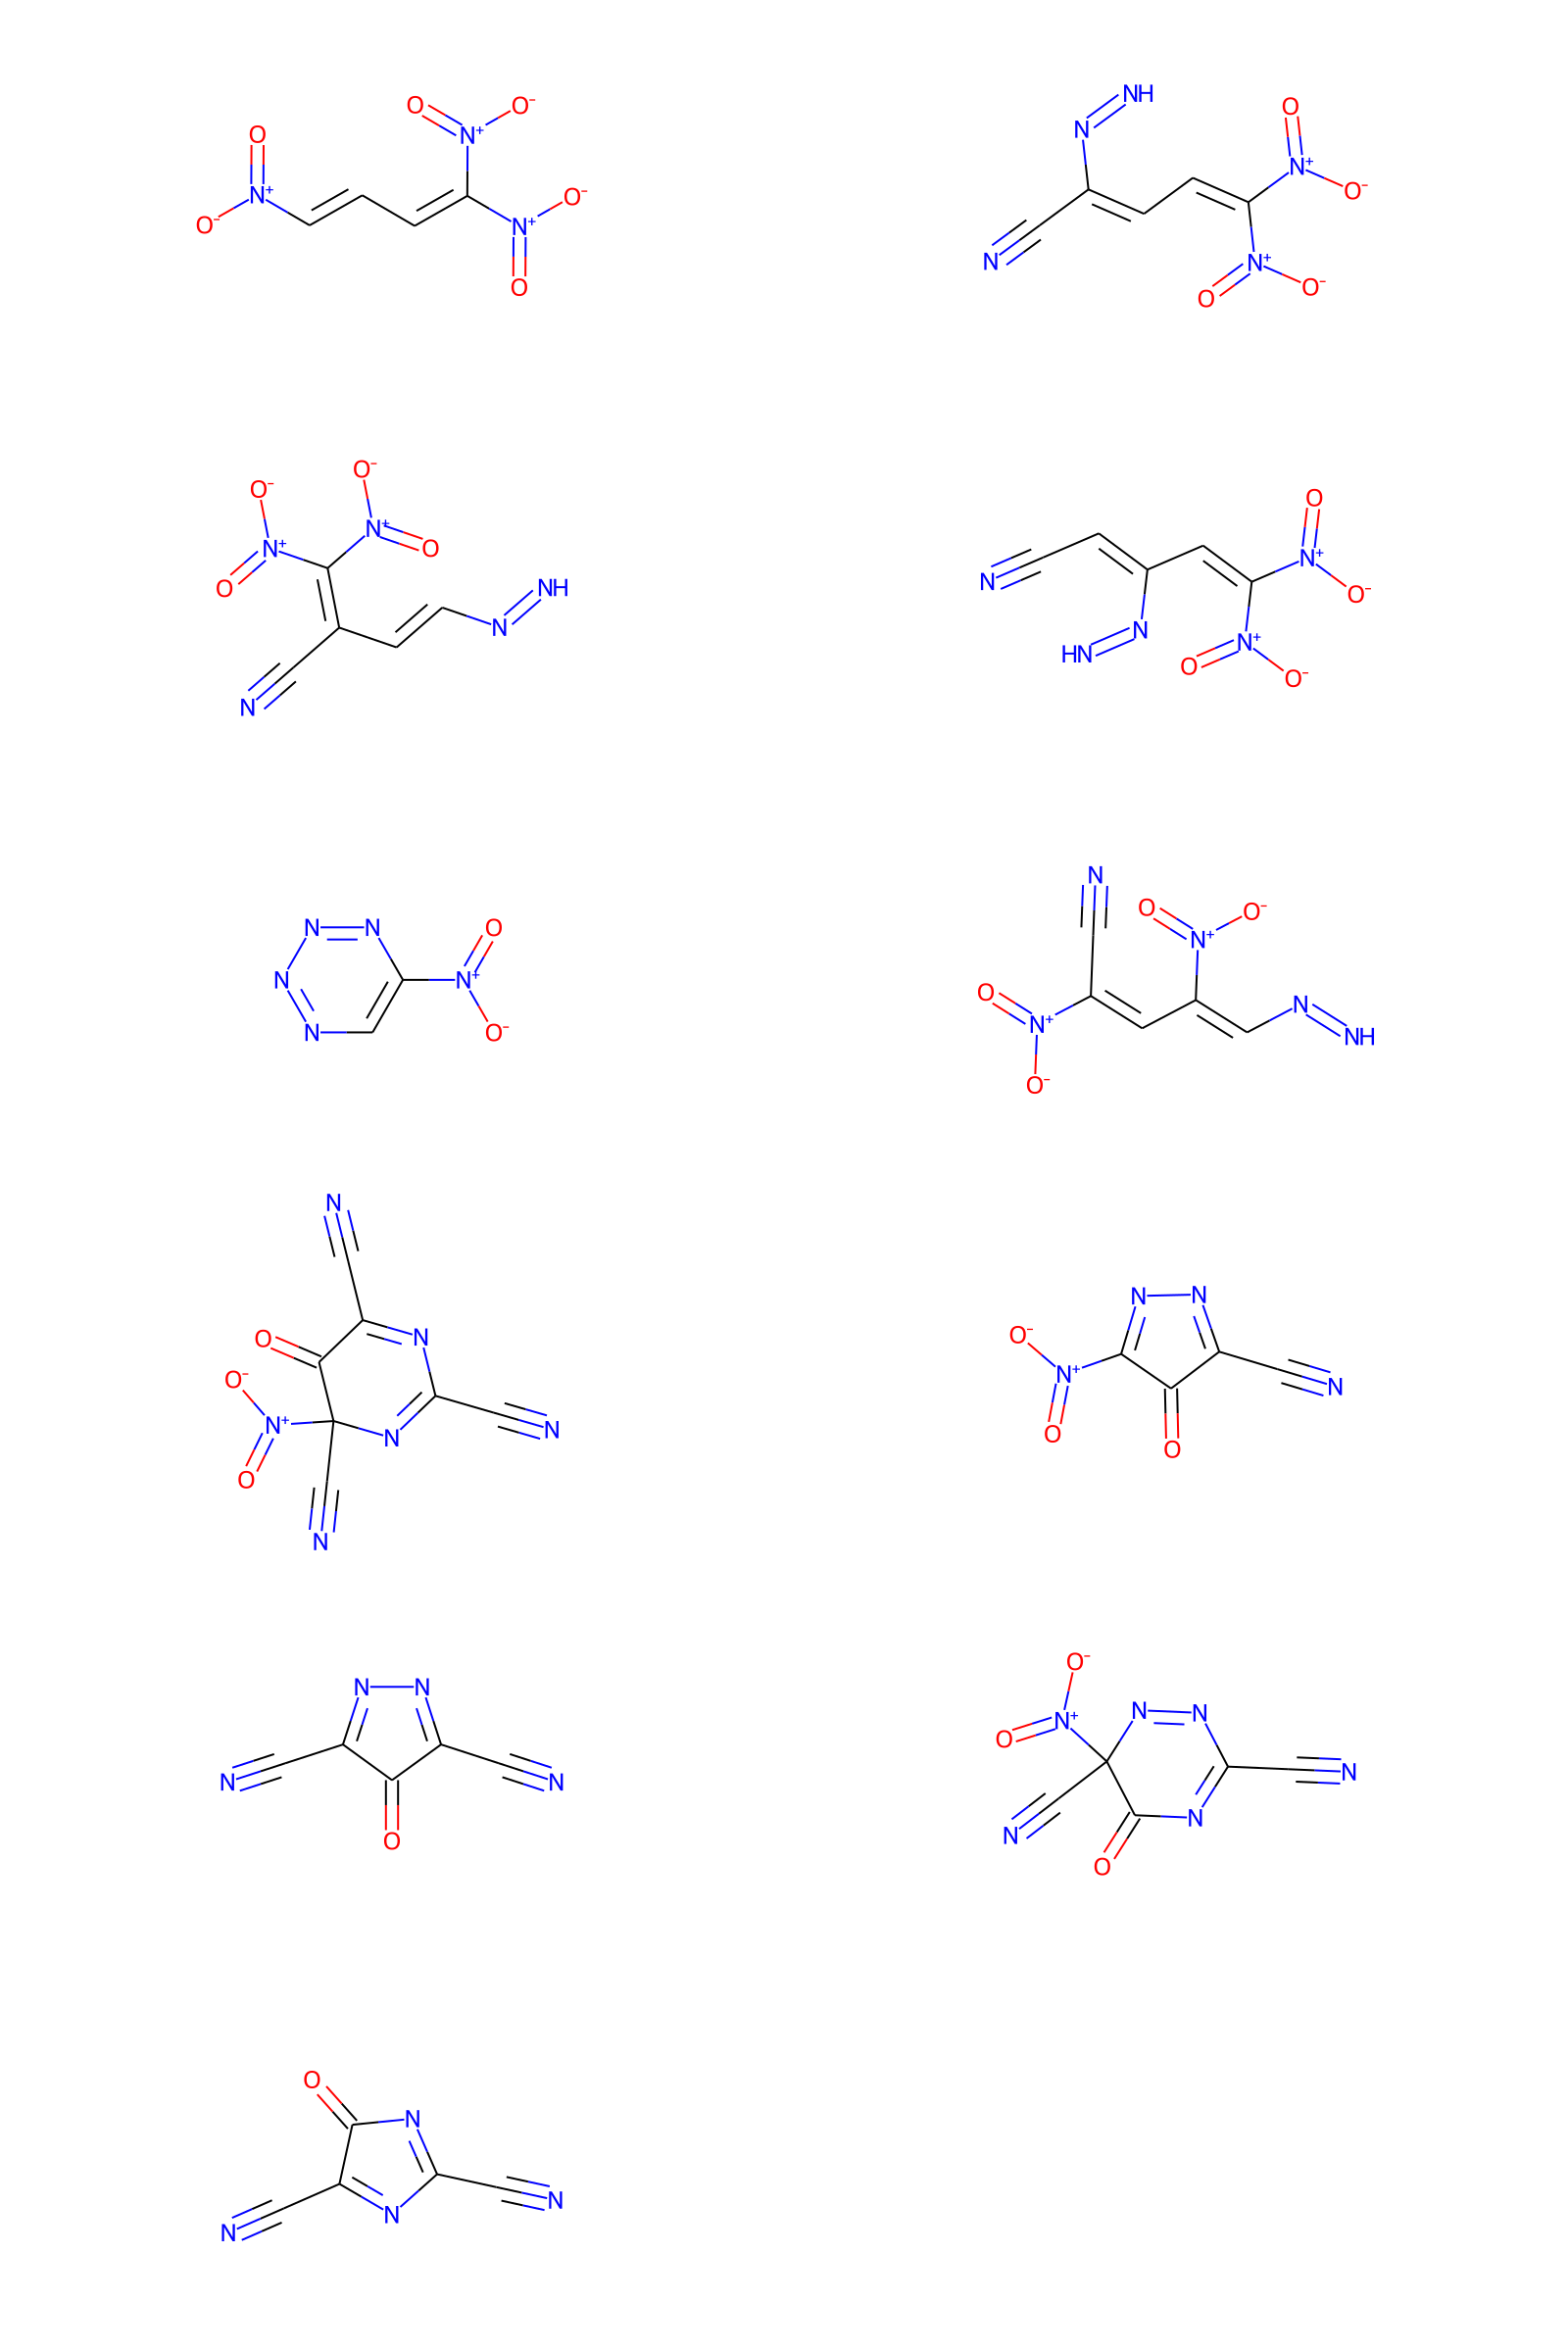

In [113]:
for i in highlight_list:
    print(i )
highlight_list_T = np.transpose(highlight_list)

img = Draw.MolsToGridImage( [Chem.MolFromSmiles(s) for s in highlight_list_T[0]], 
                           molsPerRow=2, subImgSize=(800, 400), returnPNG=False, maxMols=100,)
                           #legends=list(highlight_list_T[1]) )  
img.save('highlight_final.png')
display(img)

# Additional analysis

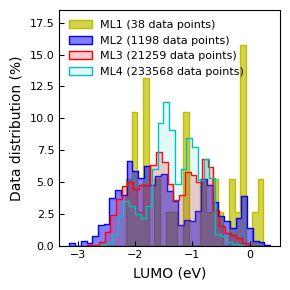

In [5]:
fig, axs = plt.subplots(1,1,figsize=(3.,3),tight_layout=True,dpi=100)
#sns.histplot(df_pnl, x='LUMO', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.9, fill=True, color='k',label=f'DFT ({len(df_pnl)} data points)', stat='percent')
sns.histplot(df1_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.7, fill=True, color='y',label=f'ML1 ({len(df1_filter)} data points)', stat='percent')
sns.histplot(df2_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.5, fill=True, color='b',label=f'ML2 ({len(df2_filter)} data points)', stat='percent')
sns.histplot(df3_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.2, fill=True, color='r',label=f'ML3 ({len(df3_filter)} data points)', stat='percent')
sns.histplot(df4_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs, element="step", alpha=0.1, fill=True, color='c',label=f'ML4 ({len(df4_filter)} data points)', stat='percent')

axs.set_ylabel('Data distribution (%)', fontsize=10)
axs.set_xlabel('LUMO (eV)', fontsize=10)
axs.tick_params(direction='in',labelsize=8)
axs.legend(fontsize=8, frameon=False, loc=2)
axs.set_ylim(top=18.5)

#plt.savefig("ML_PNL_CCCC_prediction_hist.png", dpi=800)  

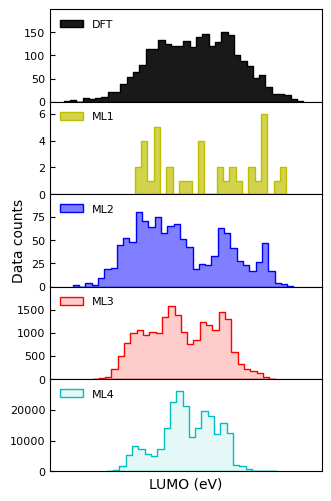

In [157]:
fig, axs = plt.subplots(5,1,figsize=(3.5,6))#,tight_layout=True,dpi=100)
sns.histplot(df_pnl, x='LUMO', kde=False, binwidth=0.1, ax=axs[0], element="step", alpha=0.9, fill=True, color='k',label=f'DFT')
sns.histplot(df1_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs[1], element="step", alpha=0.7, fill=True, color='y',label=f'ML1')
sns.histplot(df2_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs[2], element="step", alpha=0.5, fill=True, color='b',label=f'ML2')
sns.histplot(df3_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs[3], element="step", alpha=0.2, fill=True, color='r',label=f'ML3')
sns.histplot(df4_filter, x='LUMO_predicted', kde=False, binwidth=0.1, ax=axs[4], element="step", alpha=0.1, fill=True, color='c',label=f'ML4')

ymax= [199, 6.9, 99, 1999, 29999]
for n in range(0,5):
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    axs[n].set_xticks( [] )
    axs[n].set_xticklabels([])
    axs[n].set_xlim((-3.5,0.8))
    axs[n].set_ylim(top=ymax[n])
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].legend(fontsize=8, frameon=False, loc=2)
axs[4].set_xlabel('LUMO (eV)', fontsize=10)    
axs[2].set_ylabel('Data counts', fontsize=10)

plt.subplots_adjust(wspace=0, hspace=0.0)
#plt.savefig("Prediction.png", dpi=800)  

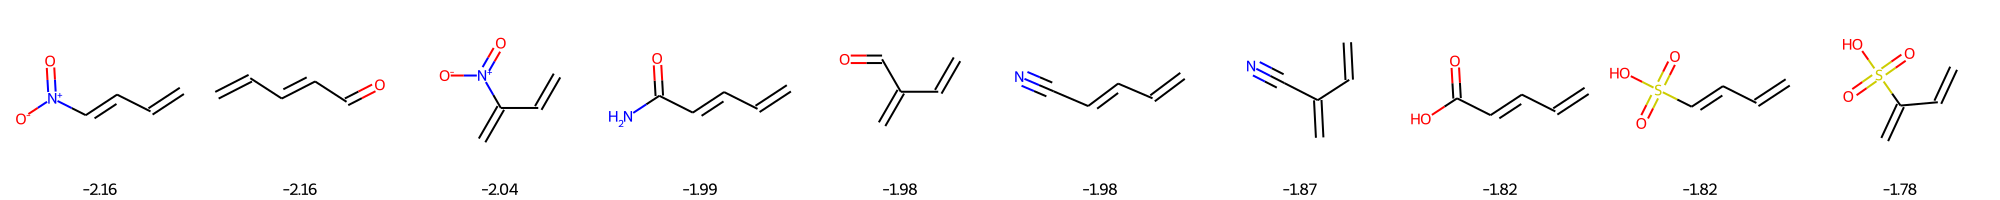

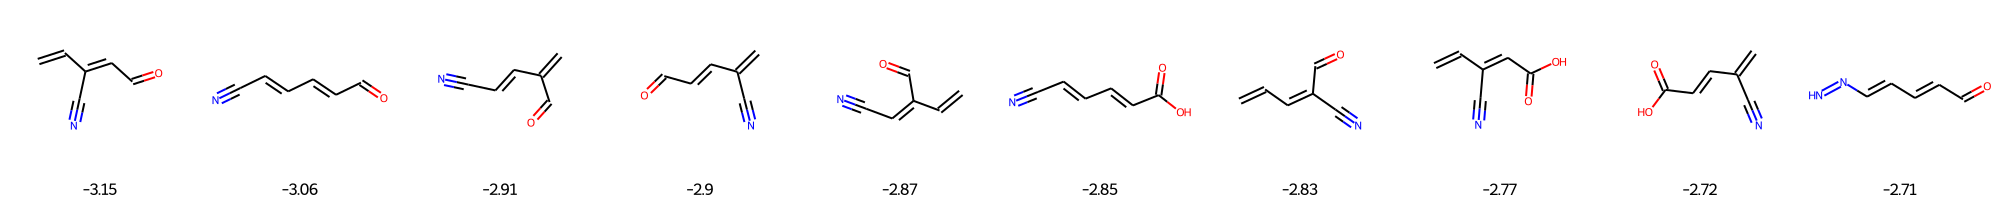

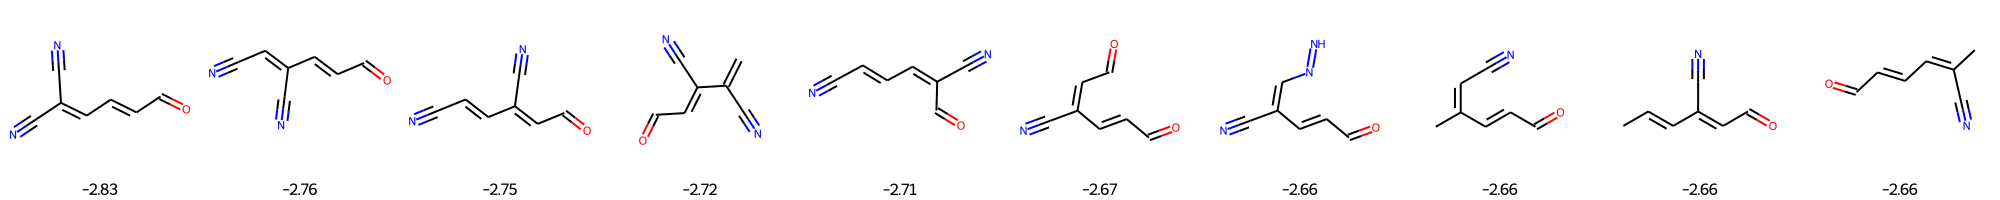

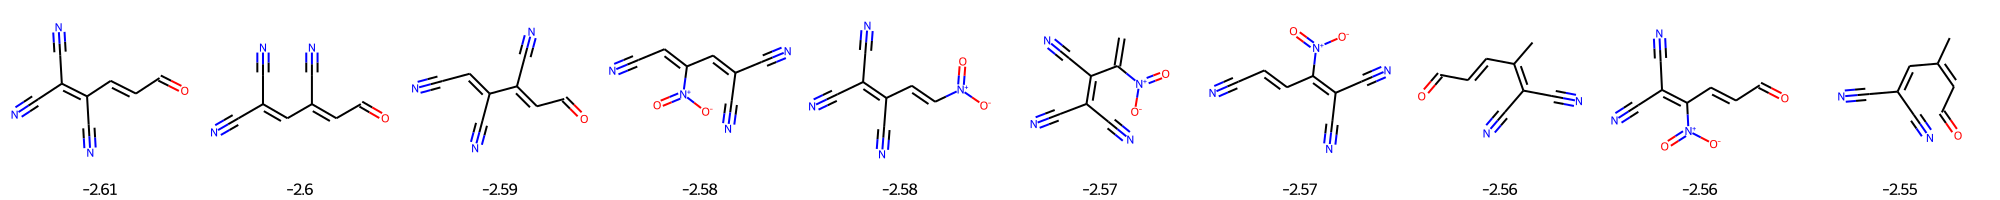

In [286]:
for top in [ df1_filter, df2_filter, df3_filter, df4_filter ]:
    top = top.head(10)
    #for l in top['LUMO_predicted']: print(l)
    img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in top['SMILES']], molsPerRow=10, legends=[str(round(p,2)) for p in top['LUMO_predicted']] )  
    display(img)

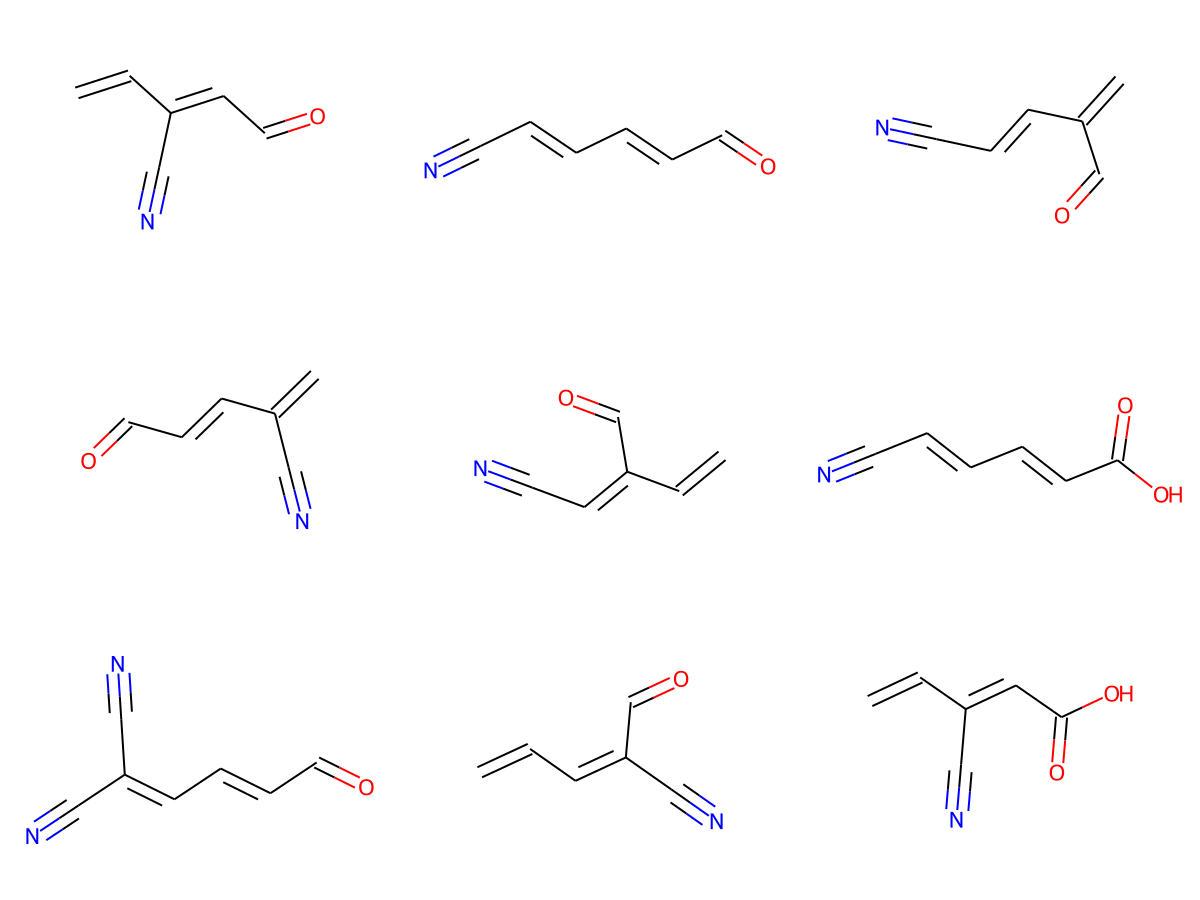

In [287]:
top = pd.concat( [ df1_filter, df2_filter, df3_filter, df4_filter ], axis=0 ).sort_values(by='LUMO_predicted',ascending=True).head(9)
#top = df2_filter.head(9)
img = Draw.MolsToGridImage( [Chem.MolFromSmiles(p) for p in top['SMILES']], molsPerRow=3, subImgSize=(400, 300), returnPNG=False,)#legends=[str(round(p,2))+' eV' for p in top['LUMO_predicted']], )  
img.save('ML_PNL_CCCC_predicted_Molecules.png')
display(img)

In [315]:
df=df_pnl.copy()
ss = []
for s in df['SMILES']:
    mol = Chem.MolFromSmiles(s)
    Chem.Kekulize(mol)
    s = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=False)
    ss.append(s)
df['SMI'] = ss

#df['SMI'] = [ Chem.CanonSmiles(s) for s in df['SMILES'] ]
for n,(s,l) in enumerate(zip(top['SMILES'],top['LUMO_predicted'])):
    ## Write XYZ
    #x = smiles_to_xyz_pybel(s, if_write_xyz=f'molecule_{n}.xyz')
    
    #s= Chem.CanonSmiles(s)   
    #inchi = Chem.MolToInchi( Chem.MolFromSmiles(s)) 
    df1 = df[df['SMI']==s]
    if len(df1)>0:
        l_ref = df1['LUMO'].values
        print(s, l, l_ref)
    else:
        print(s, l)

C=CC(C#N)=CC=O -3.148054534944163 [-3.29162262 -3.12604949]
N#CC=CC=CC=O -3.0596274636325824 [-3.25064499 -3.16320664]
C=C(C=O)C=CC#N -2.9108661218847645 [-2.93753989 -2.92926763]
C=C(C#N)C=CC=O -2.8955866862825315
C=CC(C=O)=CC#N -2.8729444457478626 [-3.13626465]
N#CC=CC=CC(=O)O -2.848597437192298 [-2.94366246 -2.93241055]
N#CC(C#N)=CC=CC=O -2.833615302941745
C=CC=C(C#N)C=O -2.8294409706036867
C=CC(C#N)=CC(=O)O -2.7748343292777884 [-2.82655826]


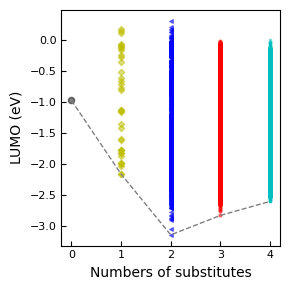

In [14]:
colors = ['k','y','b','r','c']
mk = ['o','D','<','p','*']
fig, axs = plt.subplots(1,1, figsize=(3.,3), tight_layout=True)
low_y=[]
for n,df in enumerate([df0_filter,df1_filter,df2_filter,df3_filter,df4_filter]):
    x = np.full( len(df), n )
    y = df['LUMO_predicted']
    low_y.append(np.amin(y))
    #x,y,z = color_density(x, y)
    axs.scatter(x, y, marker=mk[n], c=colors[n], cmap='jet', label='', alpha=0.5, s=20/(n+1)) 
axs.plot([0,1,2,3,4],low_y,ls='--',color='gray',lw=1)
axs.tick_params(direction='in',labelsize=8)
axs.set_ylabel('LUMO (eV)', fontsize=10)
axs.set_xlabel('Numbers of substitutes', fontsize=10)
axs.set_xticks( [0,1,2,3,4] )
plt.savefig("ML_PNL_CCCC_prediction_diagram.png", dpi=800)  
plt.show()

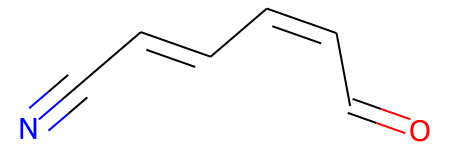

In [197]:
Chem.MolFromSmiles('N#C/C=C/C=C\C=O')

In [16]:
func_edg = ['*O','*NC','*N(C)C','*N','*OC','*NC(=O)C','*OC(=O)C','*C','*C=C']
func_ewg = ['*C=O','*C(=O)C','*C(=O)OC','*C(=O)O','*C#N','*S(=O)(=O)O','*[N+](=O)[O-]','*C=N','*C(=O)N','*N=N']
func_edg = [ Chem.CanonSmiles(f) for f in func_edg]
func_ewg = [ Chem.CanonSmiles(f) for f in func_ewg]

functional_pat1 = {
    0: [[0],[3]],
    1: [[1],[2]],
}
functional_pat2 = {
    0: [[0],[3]],
    1: [ [0,1],[2,3] ],
    2: [ [0,2],[1,3] ],
    3: [ [0,3] ],
    4: [ [1,2] ],
}

def know_functional_pattern(smiles, patterns, func_edg=func_edg, func_ewg=func_ewg):
    """
    group_type: edg -> 1, ewg ->0, None ->999
    group_loc: depends on functional_pat
    """
    functionality = locate_func(smi=smiles)
    f= sorted( list( functionality.keys() ) )
    g= [ Chem.CanonSmiles(g) for g in list(chain( *functionality.values() ) ) ]
    group_type = [ 1 if group in func_edg else 0 if group in func_ewg else 999 for group in g ]
    group_loc = [ k for k,v in patterns.items() if f in v ]
    return group_type, group_loc

In [19]:
func_info = [ know_functional_pattern(smiles=s, patterns=functional_pat1) for s in df1_filter['SMILES'] ]
df1_filter['Func_style'] = [ np.sum(f[0]) for f in func_info ]
df1_filter['Func_pattern'] =  [ f[1][0] for f in func_info ]

func_info = [ know_functional_pattern(smiles=s, patterns=functional_pat2) for s in df2_filter['SMILES'] ]
df2_filter['Func_style'] = [ np.sum(f[0]) for f in func_info ]
df2_filter['Func_pattern'] =  [ f[1][0] for f in func_info ]

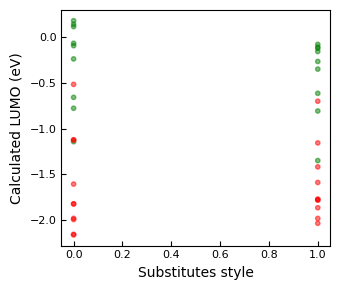

In [20]:
x,y,z = df1_filter['Func_pattern'], df1_filter['LUMO_predicted'], df1_filter['Func_style']
colors = ['r','g','b','o','c','m']
mk = ['o','D','<','p','*','v']
colors = [ colors[i] for i in z]
mk = [ mk[i] for i in x ]

fig, axs = plt.subplots(1,1, figsize=(3.5,3), tight_layout=True)
axs.scatter(x, y, marker='o', c=colors, cmap='jet', label='', alpha=0.5, s=10) 
axs.tick_params(direction='in',labelsize=8)
axs.set_ylabel('Calculated LUMO (eV)', fontsize=10)
axs.set_xlabel('Substitutes style', fontsize=10)
#axs.set_xticks( [0,1] )
#plt.savefig("ML_PNL_CCCC_prediction_diagram.png", dpi=800)  
plt.show()

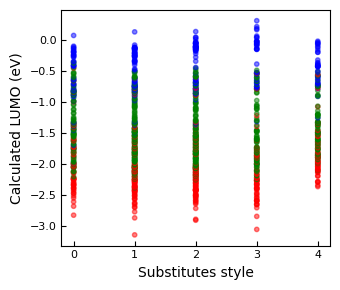

In [21]:
x,y,z =df2_filter['Func_pattern'], df2_filter['LUMO_predicted'], df2_filter['Func_style']
colors = ['r','g','b','o','c','m']
mk = ['o','D','<','p','*','v']
colors = [ colors[i] for i in z]
mk = [ mk[i] for i in x ]

fig, axs = plt.subplots(1,1, figsize=(3.5,3), tight_layout=True)
axs.scatter(x, y, marker='o', c=colors, cmap='jet', label='', alpha=0.5, s=10) 
axs.tick_params(direction='in',labelsize=8)
axs.set_ylabel('Calculated LUMO (eV)', fontsize=10)
axs.set_xlabel('Substitutes style', fontsize=10)
#axs.set_xticks( [0,1] )
plt.show()

In [26]:
pd.concat([x,y],axis=1).to_csv('tmp.csv')

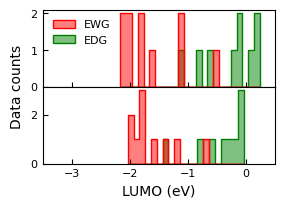

In [282]:
colors = ['r','g','b','o','c','m']
n_loc = len(df1_filter['Func_pattern'].value_counts())
fig, axs = plt.subplots(n_loc,1 ,figsize=(3,1*n_loc))#,tight_layout=True,dpi=100)
#ymax = [13,19,19,13,11]
for n in range(n_loc):
    df = df1_filter[df1_filter['Func_pattern']==n]
    sns.histplot( df, x='LUMO_predicted', hue='Func_style', kde=False, binwidth=0.1, ax=axs[n], element="step", alpha=0.5, fill=True, palette=colors, label='Style')#  )#, stat='percent', 
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_xticks( [] )
    axs[n].set_xlim((-3.5,0.5))
    #axs[n].set_ylim(top=ymax[n])
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].legend_.remove()
    if n!=n_loc-1: axs[n].set_xticklabels([])

handles, labels = axs[n_loc-1].get_legend_handles_labels()
labels = ['EDG','EWG']
axs[0].legend(handles[::-1], labels[::-1], fontsize=8, frameon=False, ncol=1, loc=2)#, bbox_to_anchor=(1,1.3), handlelength=1, handletextpad=0.2, columnspacing=1)
axs[n_loc-1].set_xlabel('LUMO (eV)', fontsize=10)    
axs[n_loc-1].set_ylabel('Data counts', fontsize=10)
axs[n_loc-1].yaxis.set_label_coords(-0.08,1.01)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("ML_PNL_CCCC_prediction_EWGEDG.png", dpi=800) 
plt.show()


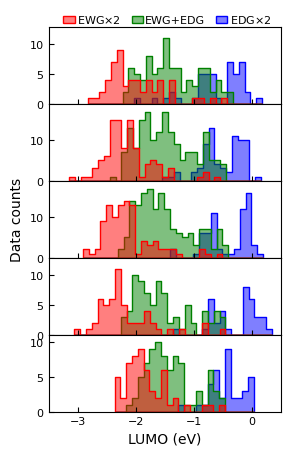

In [277]:
#from matplotlib.ticker import MaxNLocator
colors = ['r','g','b','o','c','m']
n_loc = len(df2_filter['Func_pattern'].value_counts())
fig, axs = plt.subplots(n_loc,1 ,figsize=(3,1*n_loc))#,tight_layout=True,dpi=100)
ymax = [13,19,19,13,11]
for n in range(n_loc):
    df = df2_filter[df2_filter['Func_pattern']==n]
    sns.histplot( df, x='LUMO_predicted', hue='Func_style', kde=False, binwidth=0.1, ax=axs[n], element="step", alpha=0.5, fill=True, palette=colors, label='Style')#  )#, stat='percent', 
    axs[n].set_xlabel('', fontsize=10)
    axs[n].set_ylabel('')    
    #axs[n].set_xticks( [] )
    axs[n].set_xlim((-3.5,0.5))
    axs[n].set_ylim(top=ymax[n])
    axs[n].tick_params(direction='in',labelsize=8)
    axs[n].legend_.remove()
    if n!=n_loc-1: axs[n].set_xticklabels([])
    #axs[n].yaxis.set_major_locator(MaxNLocator(integer=True))

handles, labels = axs[n_loc-1].get_legend_handles_labels()
labels = [r'EDG$\times$2','EWG+EDG',r'EWG$\times$2']
axs[0].legend(handles[::-1], labels[::-1], fontsize=8, frameon=False, ncol=3, bbox_to_anchor=(1,1.3), handlelength=1, handletextpad=0.2, columnspacing=1)
axs[n_loc-1].set_xlabel('LUMO (eV)', fontsize=10)    
axs[2].set_ylabel('Data counts', fontsize=10)
#axs[n_loc-1].set_xticklabels([-3.5,-2.5,-1.5,-0.5,0.5])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("ML_PNL_CCCC_prediction_EWGEDG2.png", dpi=800) 
plt.show()
